# readme
descrip: plot total, mean and eddy fluxes <br> 

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
steps: <br>
1. finalize UET+VNT depth integration plot
2. interp temp from T grids to U grids 
3. compute 

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

from tqdm import tqdm

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.172:42206")
client

<Client: 'tcp://10.73.3.172:42206' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200+50, 700-50 
nlat1_r_t12, nlat2_r_t12 = 1300+100, 2000-100

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

chunks_HR = {'nlat':400,'nlon':400}
# chunks_HR = {'time': 1}
# chunks_LR = {'nlat':384,'nlon':320/5,'z_t':1}
# ===========================================================

In [4]:
# read U, V vel TH 

# --- read one file ---
# infile_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UET/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UET.200601-200612.nc')
# ds_uet_TH = xr.open_dataset(infile_uet_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uet_TH

# infile_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VNT/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VNT.200601-200612.nc')
# ds_vnt_TH = xr.open_dataset(infile_vnt_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vnt_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(1900,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UET/')
infiles1a_uet_TH = [indir1a_uet_TH + prefix1a_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uet_TH

# indir1a_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNT/')
# infiles1a_vnt_TH = [indir1a_vnt_TH + prefix1a_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
#                for iyr in yrs1a_TH]
# infiles1a_vnt_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UET/')
infiles2_uet_TH = [indir1b_uet_TH + prefix2_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uet_TH

# indir1b_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VNT/')
# infiles2_vnt_TH = [indir1b_vnt_TH + prefix2_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
#                for iyr in yrs2_TH]
# infiles2_vnt_TH

ds_uet_TH = xr.open_mfdataset(infiles1a_uet_TH + infiles2_uet_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

# ds_vnt_TH = xr.open_mfdataset(infiles1a_vnt_TH + infiles2_vnt_TH, compat="override", combine="by_coords", 
#                                data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_uet_TH first time: ', ds_uet_TH.time[0].values)
print('ds_uet_TH end time: ', ds_uet_TH.time[-1].values)
print('ds_uet_TH # time: ', len(ds_uet_TH.time))
#ds_vnt_TH

ds_uet_TH first time:  1900-02-01 00:00:00
ds_uet_TH end time:  2101-01-01 00:00:00
ds_uet_TH # time:  2412


In [5]:
indir1a_ues_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UES/')
infiles1a_ues_TH = [indir1a_ues_TH + prefix1a_TH + 'UES.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_ues_TH

indir1b_ues_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UES/')
infiles2_ues_TH = [indir1b_ues_TH + prefix2_TH + 'UES.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_ues_TH

ds_ues_TH = xr.open_mfdataset(infiles1a_ues_TH + infiles2_ues_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_ues_TH first time: ', ds_ues_TH.time[0].values)
print('ds_ues_TH end time: ', ds_ues_TH.time[-1].values)
print('ds_ues_TH # time: ', len(ds_ues_TH.time))

ds_ues_TH first time:  1900-02-01 00:00:00
ds_ues_TH end time:  2101-01-01 00:00:00
ds_ues_TH # time:  2412


In [6]:
# read U, V vel TH 

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-200612.nc')
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uvel_TH

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-200612.nc')
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vvel_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH

prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

# ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
#                                data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_uvel_TH first time: ', ds_uvel_TH.time[0].values)
print('ds_uvel_TH end time: ', ds_uvel_TH.time[-1].values)
print('ds_uvel_TH # time: ', len(ds_uvel_TH.time))
#ds_vvel_TH

ds_uvel_TH first time:  1900-02-01 00:00:00
ds_uvel_TH end time:  2101-01-01 00:00:00
ds_uvel_TH # time:  2412


In [7]:
# read TEMP, PD TH 

# --- read one file ---
# infile_pd_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/PD/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.PD.200601-200612.nc')
# ds_pd_TH = xr.open_dataset(infile_pd_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_pd_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'


indir1a_pd_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/PD/')
infiles1a_pd_TH = [indir1a_pd_TH + prefix1a_TH + 'PD.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_pd_TH


prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'

indir1b_pd_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/PD/')
infiles2_pd_TH = [indir1b_pd_TH + prefix2_TH + 'PD.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_pd_TH


ds_pd_TH = xr.open_mfdataset(infiles1a_pd_TH + infiles2_pd_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_pd_TH first time: ', ds_pd_TH.time[0].values)
print('ds_pd_TH end time: ', ds_pd_TH.time[-1].values)
print('ds_pd_TH # time: ', len(ds_pd_TH.time))
#ds_pd_TH

ds_pd_TH first time:  1900-02-01 00:00:00
ds_pd_TH end time:  2101-01-01 00:00:00
ds_pd_TH # time:  2412


In [8]:
# read TEMP, SALT TH 

# --- read one file ---
# infile_temp_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/TEMP/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.TEMP.200601-200612.nc')
# ds_temp_TH = xr.open_dataset(infile_temp_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_temp_TH

# infile_salt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SALT/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.SALT.200601-200612.nc')
# ds_salt_TH = xr.open_dataset(infile_salt_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_salt_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_temp_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/TEMP/')
infiles1a_temp_TH = [indir1a_temp_TH + prefix1a_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_temp_TH

indir1a_salt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SALT/')
infiles1a_salt_TH = [indir1a_salt_TH + prefix1a_TH + 'SALT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_salt_TH


prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_temp_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/TEMP/')
infiles2_temp_TH = [indir1b_temp_TH + prefix2_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_temp_TH

indir1b_salt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SALT/')
infiles2_salt_TH = [indir1b_salt_TH + prefix2_TH + 'SALT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_salt_TH


ds_temp_TH = xr.open_mfdataset(infiles1a_temp_TH + infiles2_temp_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_salt_TH = xr.open_mfdataset(infiles1a_salt_TH + infiles2_salt_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_salt_TH first time: ', ds_salt_TH.time[0].values)
print('ds_salt_TH end time: ', ds_salt_TH.time[-1].values)
print('ds_salt_TH # time: ', len(ds_salt_TH.time))
#ds_salt_TH

ds_salt_TH first time:  1900-02-01 00:00:00
ds_salt_TH end time:  2101-01-01 00:00:00
ds_salt_TH # time:  2412


In [9]:
# supplimentary files 
# infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
#               'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# ds_t12 = xr.open_dataset(infile_t12)
# ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12

# ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
#                        nlat=slice(nlat1_r_t12, nlat2_r_t12))

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, z_t: 62)
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    DZU      (z_t, nlat, nlon) float64 ...

# data analysis

In [10]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_pd_TH.time[0].values, ds_pd_TH.time[-1].values, len(ds_pd_TH.time)) 

time_pd_s_TH = ds_pd_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
# ds_uet_TH = ds_uet_TH_raw.assign_coords(time=time_hdift_s_TL).sel(time=slice('2001','2100'))

ds_pd_TH = ds_pd_TH.assign_coords(time=time_pd_s_TH)

1900-02-01 00:00:00 2101-01-01 00:00:00 2412


In [11]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_uvel_TH.time[0].values, ds_uvel_TH.time[-1].values, len(ds_uvel_TH.time)) 
# print(ds_vvel_TH.time[0].values, ds_vvel_TH.time[-1].values, len(ds_vvel_TH.time)) 
print(ds_temp_TH.time[0].values, ds_temp_TH.time[-1].values, len(ds_temp_TH.time)) 
print(ds_salt_TH.time[0].values, ds_salt_TH.time[-1].values, len(ds_salt_TH.time)) 
print(ds_uet_TH.time[0].values, ds_uet_TH.time[-1].values, len(ds_uet_TH.time)) 
print(ds_ues_TH.time[0].values, ds_ues_TH.time[-1].values, len(ds_ues_TH.time)) 

time_uvel_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
# ds_uet_TH = ds_uet_TH_raw.assign_coords(time=time_hdift_s_TL).sel(time=slice('2001','2100'))

ds_uvel_TH = ds_uvel_TH.assign_coords(time=time_uvel_s_TH)
# ds_vvel_TH = ds_vvel_TH.assign_coords(time=time_uvel_s_TH)
ds_temp_TH = ds_temp_TH.assign_coords(time=time_uvel_s_TH)
ds_salt_TH = ds_salt_TH.assign_coords(time=time_uvel_s_TH)
ds_uet_TH = ds_uet_TH.assign_coords(time=time_uvel_s_TH)
ds_ues_TH = ds_ues_TH.assign_coords(time=time_uvel_s_TH)

1900-02-01 00:00:00 2101-01-01 00:00:00 2412
1900-02-01 00:00:00 2101-01-01 00:00:00 2412
1900-02-01 00:00:00 2101-01-01 00:00:00 2412
1900-02-01 00:00:00 2101-01-01 00:00:00 2412
1900-02-01 00:00:00 2101-01-01 00:00:00 2412


In [12]:
# function to compute gradient 
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb

def x_gradh(F, grid):
    """
    gradient of scalar xgcm_metrics
    for pop
    """
    F_yi = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    F_xi = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdx = grid.derivative(F_yi, axis="X", boundary="extend")
    dFdy = grid.derivative(F_xi, axis="Y", boundary="extend")
    return dFdx, dFdy

In [13]:
# ds_pd_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_pd_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm

# # ds_uvel_TH.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12)).TLONG
# # ilat1_t12, ilat2_t12 = 1500,1510
# # ilon1_t12, ilon2_t12 = 280, 320
# ilat1_t12, ilat2_t12 = 1500-50, 1510+50
# ilon1_t12, ilon2_t12 = 280, 320+60

# ds_pd_r_TH = ds_pd_TH.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
# print(ds_pd_r_TH.PD.dims)

# metrics = {
#     ("X",): ["DXU", "DXT"],  # X distances
#     ("Y",): ["DYU", "DYT"],  # Y distances
#     ("Z",): ["DZU", "DZT"],  # Z distances
#     ("X", "Y"): ["UAREA", "TAREA"],}


# grid_pd_r_TH, xds_pd_r_TH = pop_tools.to_xgcm_grid_dataset(ds_pd_r_TH, 
#                                                            periodic=False,
#                                                            metrics=metrics,
#                                                            boundary={"X": "extend", "Y": "extend", "Z": "extend"},)


# for coord in ["nlat", "nlon"]:
#     if coord in xds_pd_r_TH.coords:
#         xds_pd_r_TH = xds_pd_r_TH.drop_vars(coord)
        
# xds_pd_r_TH

# print(xds_pd_r_TH.PD.dims)

# # pd_z_r_TH = ds_pd_TH.PD.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12),z_t=0)
# kmt_r_TH = xds_pd_r_TH.KMT
# pd_z_rm_TH = xds_pd_r_TH.PD.isel(z_t=0).where(kmt_r_TH>0, np.nan)*1000 - 1000

# # pd1_z_rm_TH = (pd_z_rm_TH-1)*1000

# # compute gradient and geostrohpic vel
# dpddx_TH, dpddy_TH = x_gradh(pd_z_rm_TH, grid_pd_r_TH)  # xgcm metrics version
# print(dpddx_TH.dims)
# print(dpddy_TH.dims)
# grad_pd_amp_TH = xr.ufuncs.sqrt(dpddx_TH**2 + dpddy_TH**2)

# fig, axs = plt.subplots(3,2, figsize=(10,8))
# pd_z_rm_TH.isel(time=0).plot(ax=axs[0,0],cmap='ColdHot')
# grad_pd_amp_TH.isel(time=0).plot(ax=axs[0,1],vmin=0, vmax=5e-7, cmap='viridis')

In [14]:
ds_temp_TH["SALT"] = ds_salt_TH.SALT
ds_temp_TH["UVEL"] = ds_uvel_TH.UVEL
ds_temp_TH["UET"] = ds_uet_TH.UET
ds_temp_TH["UES"] = ds_ues_TH.UES
ds_temp_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
ds_temp_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_temp_TH.DZT.attrs["long_name"] = "Thickness of T cells"
ds_temp_TH.DZT.attrs["units"] = "centimeter"
ds_temp_TH.DZT.attrs["grid_loc"] = "3111"
ds_temp_TH.DZU.attrs["long_name"] = "Thickness of U cells"
ds_temp_TH.DZU.attrs["units"] = "centimeter"
ds_temp_TH.DZU.attrs["grid_loc"] = "3221"

ilat1_t12, ilat2_t12 = 1500-50, 1510+50
ilon1_t12, ilon2_t12 = 280, 320+60

metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],}

ds_temp_r_TH = ds_temp_TH.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
print(ds_temp_r_TH.dims)

grid_temp_r_TH, xds_temp_r_TH = pop_tools.to_xgcm_grid_dataset(ds_temp_r_TH, 
                                                           periodic=False,
                                                           metrics=metrics,
                                                           boundary={"X": "extend", "Y": "extend", "Z": "extend"},)


for coord in ["nlat", "nlon"]:
    if coord in xds_temp_r_TH.coords:
        xds_temp_r_TH = xds_temp_r_TH.drop_vars(coord)
        
xds_temp_r_TH

Frozen(SortedKeysDict({'z_t': 62, 'z_t_150m': 15, 'z_w': 62, 'z_w_top': 62, 'z_w_bot': 62, 'nlat': 110, 'nlon': 100, 'time': 2412, 'd2': 2}))


<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 110, nlat_u: 110, nlon_t: 100, nlon_u: 100, time: 2412, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
  * time                (time) object 1900-01-31 00:00:00 ... 2100-12-31 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 7 ... 105 106 107 108 109 110
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 3.5 ... 96.5 97.5 98.5 99.5
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 3.5 ... 107.5 108.5 109.5
Dimensions without coordinates: d2
Data variables: (12/57)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(110, 100), meta=np.ndarray>
    ...                  ...
    SALT                (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 62, 110, 100), meta=np.ndarray>
    UVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 110, 100), meta=np.ndarray>
    UET                 (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(12, 62, 110, 100), meta=np.ndarray>
    UES                 (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(12, 62, 110, 100), meta=np.ndarray>
    DZU                 (z_t, nlat_u, nlon_u) float64 1e+03 1e+03 ... nan nan
    DZT                 (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 ... nan nan
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Wed Aug 25 22:11:28 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2019-12-09 at 01:35:34.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  11407331
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [33]:
uet_tot_tre_front_TH
# dzt_front_TH

<xarray.DataArray 'mul-daed19a0e811fde912a5b3e5c0bec371' (time: 792, z_t: 62, nlat_t: 76)>
dask.array<stack, shape=(792, 62, 76), dtype=float32, chunksize=(1, 62, 76), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1901-12-01 00:00:00 ... 2099-09-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 9.5 10.5 11.5 12.5 13.5 ... 81.5 82.5 83.5 84.5
    nlon_t   float64 19.5

[ 0.  0.  3.  3.  3.  4.  3.  3.  3.  4.  4.  4.  4.  4.  5.  4.  5.  5.
  7.  7.  6.  7.  8.  9. 12. 15. 17. 18. 20. 23. 26. 28. 30. 30. 29. 28.
 27. 26. 26. 26. 27. 27. 27. 26. 24. 22. 19. 16. 14. 12.  8.  5.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  0.  0.  0.]
('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
('time', 'z_t', 'nlat_u', 'nlon_u')
('time', 'z_t', 'nlat_u', 'nlon_t')
('time', 'z_t', 'nlat_u', 'nlon_t')
('time', 'nlat_t')
792 792 792


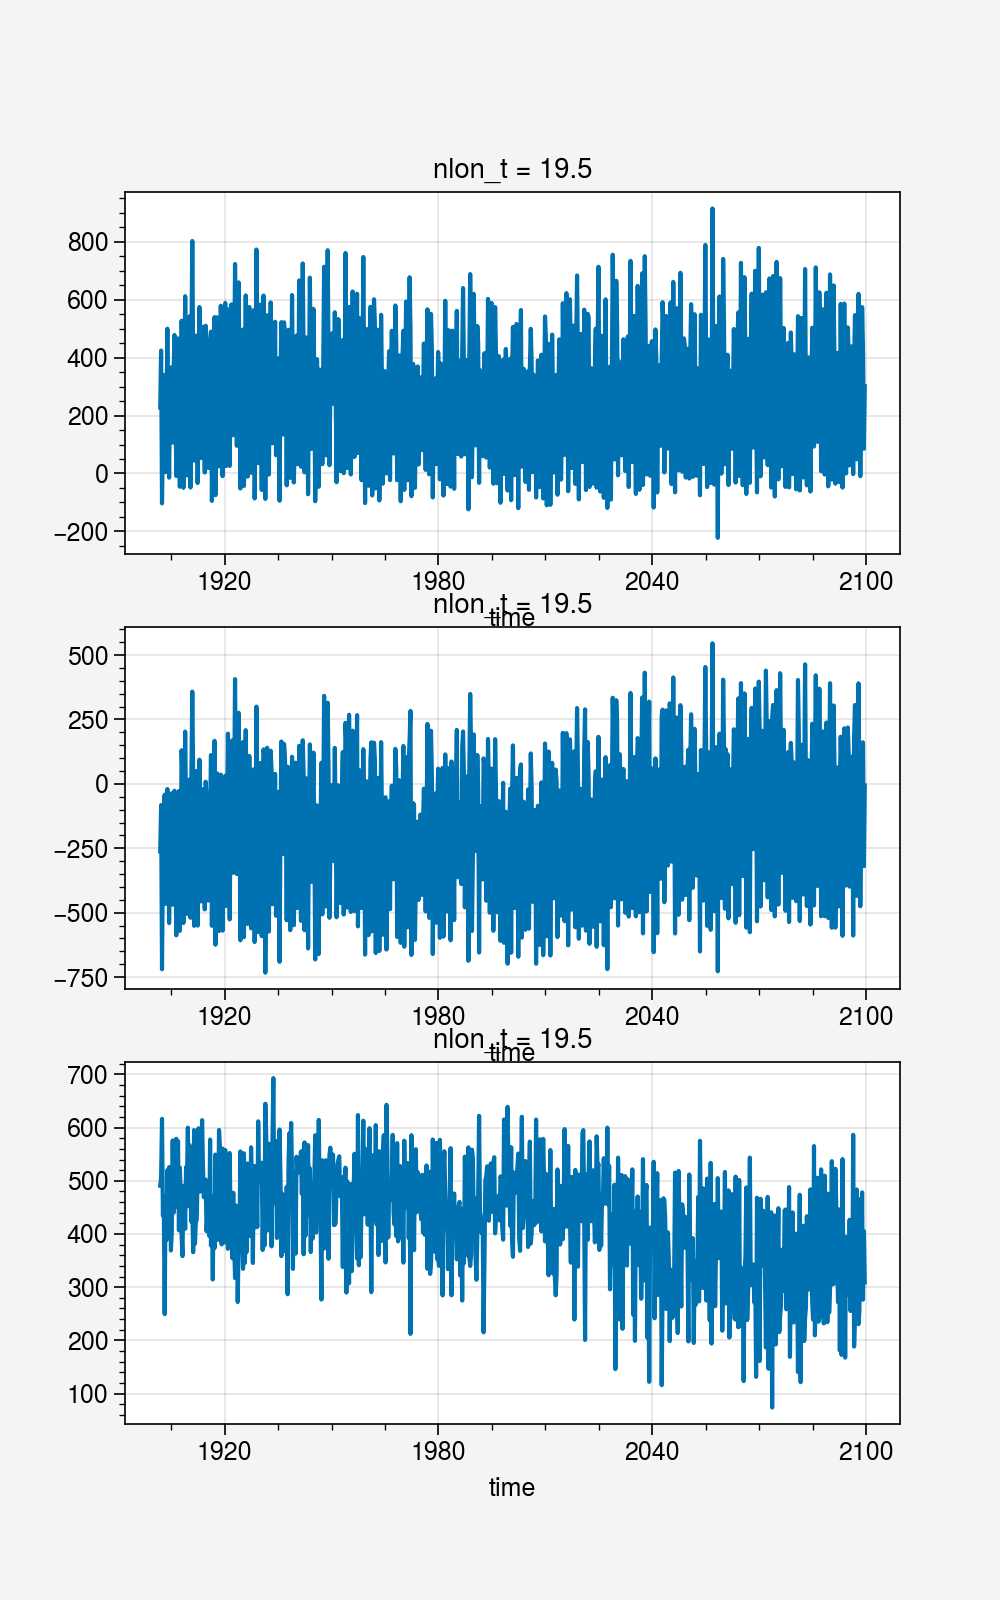

In [15]:
# --- choose region box ---
kmt_r_TH = xds_temp_r_TH.KMT
print(kmt_r_TH.sel(nlon_t=19.5,nlat_t=slice(9,85)).values) 
# -------------------------

# --- compute total flux ---
print(xds_temp_r_TH.UET.dims)
uet_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UET, 'X')
print(uet_xintp_r_TH.dims)

print(xds_temp_r_TH.UES.dims)
ues_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UES, 'X')
print(ues_xintp_r_TH.dims)

uet_tot_tre_front_TH = uet_xintp_r_TH.sel(nlon_t=19.5, nlat_t=slice(9,85)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time') 
# [degC/s]
ues_tot_tre_front_TH = ues_xintp_r_TH.sel(nlon_t=19.5, nlat_t=slice(9,85)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
dzt_front_TH = xds_temp_r_TH.DZT.sel(nlon_t=19.5, nlat_t=slice(9,85))

uet_tot_tre_zint_front_TH = (uet_tot_tre_front_TH*dzt_front_TH).sum('z_t')
ues_tot_tre_zint_front_TH = (ues_tot_tre_front_TH*dzt_front_TH).sum('z_t')
# --------------------------

# -- compute mean flow flux ---
print(xds_temp_r_TH.UVEL.dims)
uvel_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UVEL, 'X')
print(uvel_xintp_r_TH.dims)

print(uvel_xintp_r_TH.dims)
uvel_xyintp_r_TH = grid_temp_r_TH.interp(uvel_xintp_r_TH, 'Y')
uvel_xyintp_r_TH

temp_tre_front_TH = xds_temp_r_TH.TEMP.sel(nlon_t=19.5, nlat_t=slice(9,85)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
uvel_tre_front_TH = uvel_xyintp_r_TH.sel(nlon_t=19.5, nlat_t=slice(9,85)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
salt_tre_front_TH = xds_temp_r_TH.SALT.sel(nlon_t=19.5, nlat_t=slice(9,85)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
dxt_front_TH = xds_temp_r_TH.DXT.sel(nlon_t=19.5, nlat_t=slice(9,85))

uet_mfl_tre_front_TH = uvel_tre_front_TH*temp_tre_front_TH/dxt_front_TH # [degC/s]
ues_mfl_tre_front_TH = uvel_tre_front_TH*salt_tre_front_TH/dxt_front_TH # 

uet_mfl_tre_zint_front_TH = (uet_mfl_tre_front_TH*dzt_front_TH).sum('z_t')
ues_mfl_tre_zint_front_TH = (ues_mfl_tre_front_TH*dzt_front_TH).sum('z_t')
# ----------------------------

# -- compute eddy flux ---
uet_eddy_tre_front_TH = uet_tot_tre_front_TH - uet_mfl_tre_front_TH
ues_eddy_tre_front_TH = ues_tot_tre_front_TH - ues_mfl_tre_front_TH
uet_eddy_tre_zint_front_TH = (uet_eddy_tre_front_TH*dzt_front_TH).sum('z_t')
ues_eddy_tre_zint_front_TH = (ues_eddy_tre_front_TH*dzt_front_TH).sum('z_t')
# ------------------------

# --- compute mass flux ---
uerho_tot_front_TH = (-2.5e-4*uet_tot_tre_zint_front_TH + 7.6e-4*ues_tot_tre_zint_front_TH)
uerho_mfl_front_TH = (-2.5e-4*uet_mfl_tre_zint_front_TH + 7.6e-4*ues_mfl_tre_zint_front_TH)
uerho_eddy_front_TH = (-2.5e-4*uet_eddy_tre_zint_front_TH + 7.6e-4*ues_eddy_tre_zint_front_TH)

dyt_front_TH = xds_temp_r_TH.DYT.sel(nlon_t=19.5, nlat_t=slice(9,85))
uerho_tot_yint_front_TH = (uerho_tot_front_TH*dyt_front_TH).sum('nlat_t').persist()
uerho_mfl_yint_front_TH = (uerho_mfl_front_TH*dyt_front_TH).sum('nlat_t').persist()
uerho_eddy_yint_front_TH = (uerho_eddy_front_TH*dyt_front_TH).sum('nlat_t').persist()

print(uerho_eddy_front_TH.dims)
print(len(uerho_tot_front_TH), len(uerho_mfl_front_TH), len(uerho_eddy_front_TH))
# -------------------------

fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_yint_front_TH.plot(ax=axs[0]) # .resample(time='A').mean()
uerho_mfl_yint_front_TH.plot(ax=axs[1])
uerho_eddy_yint_front_TH.plot(ax=axs[2])
# axs[2].set_ylim([0,0.0002])

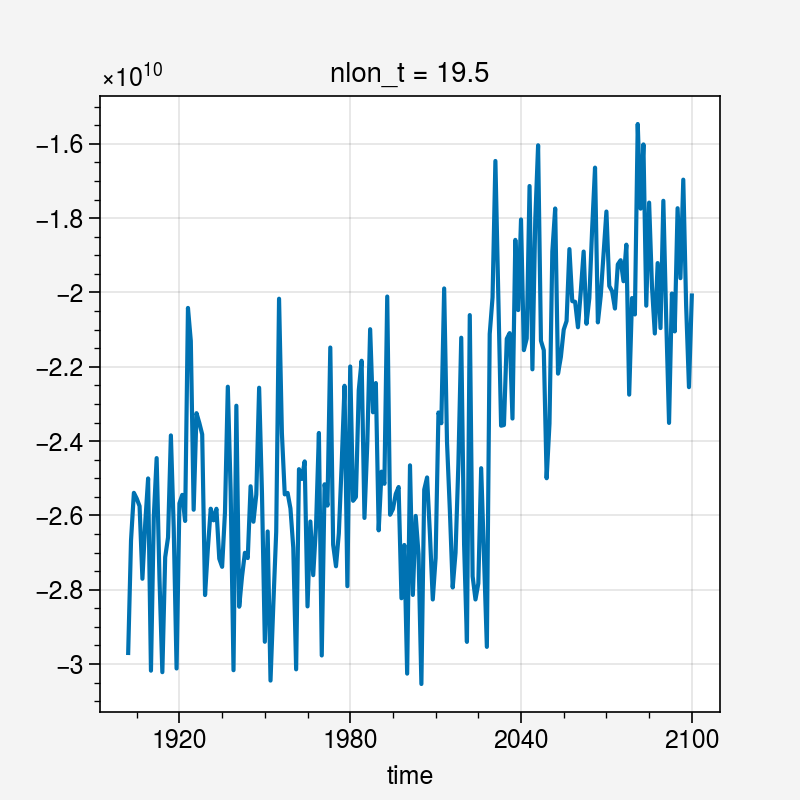

In [36]:
uvel_tre_zint_front_TH = (uvel_tre_front_TH*dzt_front_TH).sum('z_t')
uvel_tre_zyint_front_TH =(uvel_tre_zint_front_TH*dyt_front_TH).sum('nlat_t')
uvel_tre_zyint_front_TH.resample(time='A').mean('time').plot()

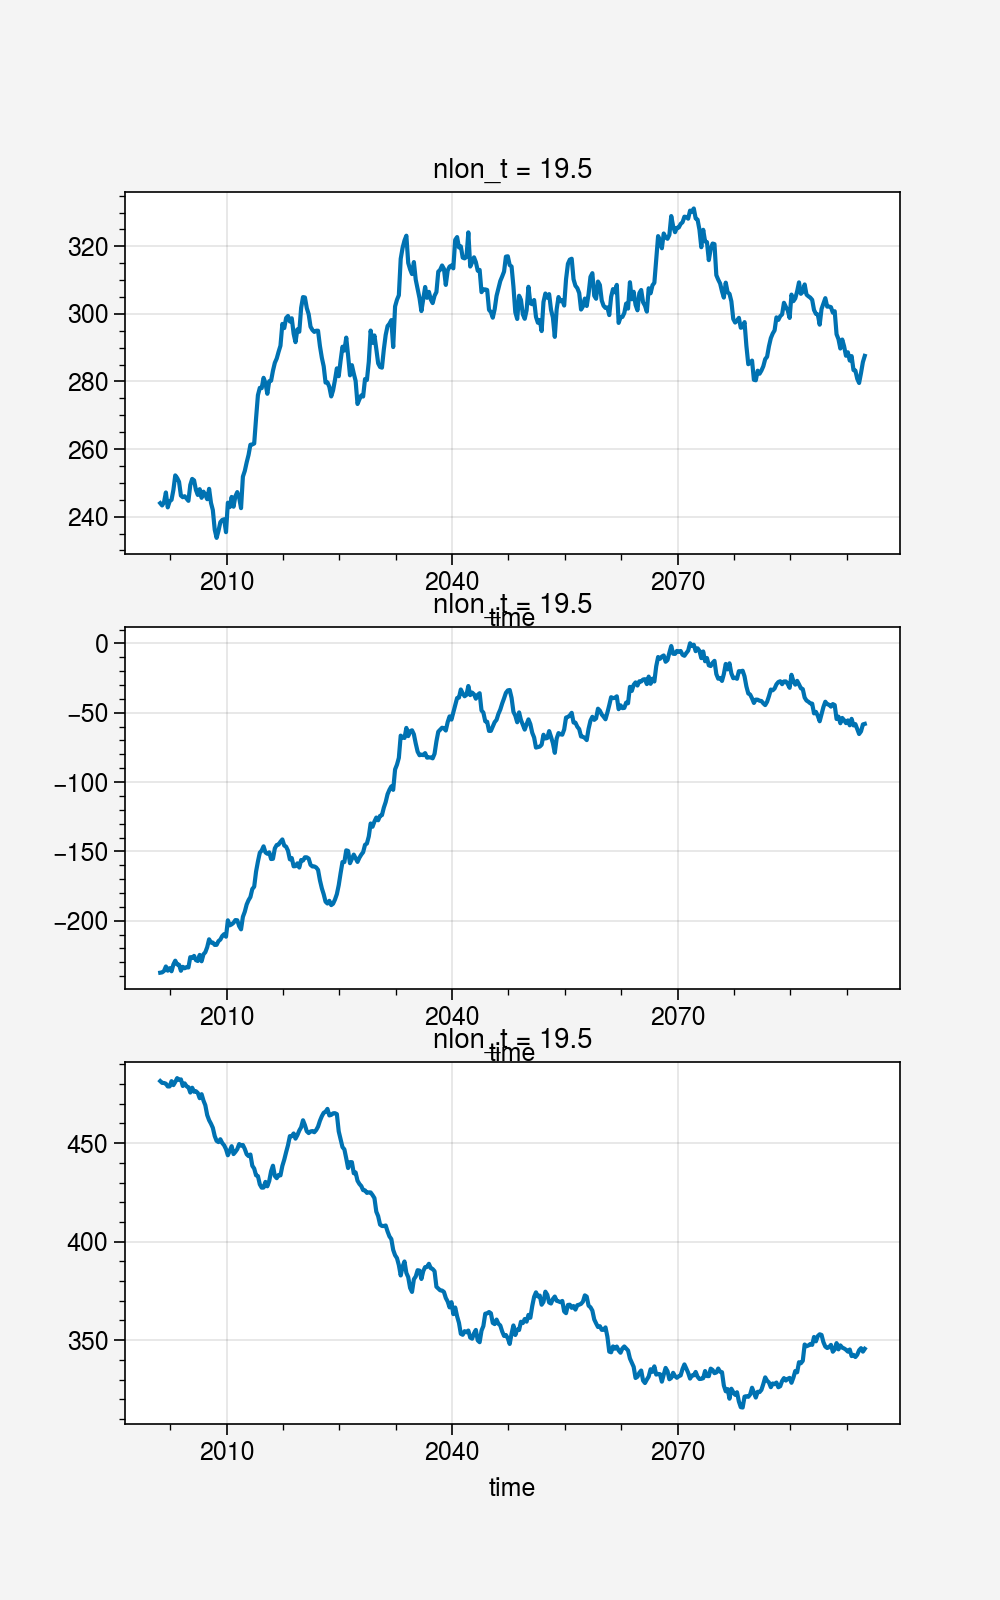

In [47]:
fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_yint_front_TH.rolling(time=40, center=True).mean('time').sel(time=slice('2001','2100')).plot(ax=axs[0]) # .resample(time='A').mean()
uerho_mfl_yint_front_TH.rolling(time=40, center=True).mean('time').sel(time=slice('2001','2100')).plot(ax=axs[1])
uerho_eddy_yint_front_TH.rolling(time=40, center=True).mean('time').sel(time=slice('2001','2100')).plot(ax=axs[2])
# axs[2].set_ylim([0,0.0002])

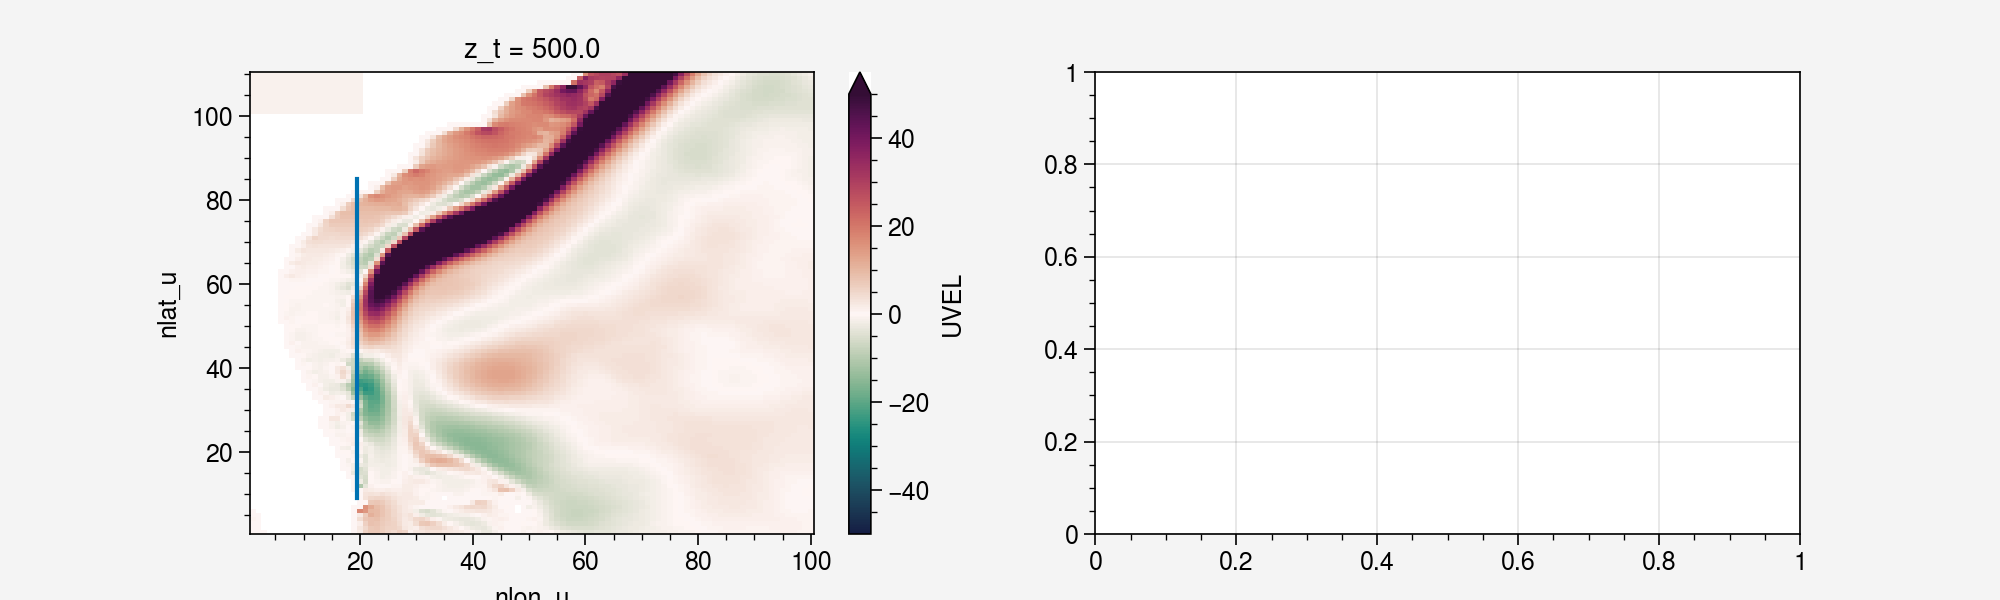

In [42]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
xds_temp_r_TH.UVEL.isel(z_t=0).sel(time=slice('2001','2020')).mean('time').plot(ax=axs[0],vmin=-50,vmax=50,cmap='curl')
axs[0].plot([19.5,19.5], [9,85])

('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
('time', 'z_t', 'nlat_u', 'nlon_u')
('time', 'z_t', 'nlat_u', 'nlon_t')
('time', 'z_t', 'nlat_u', 'nlon_t')
('time', 'nlat_t')
792 792 792


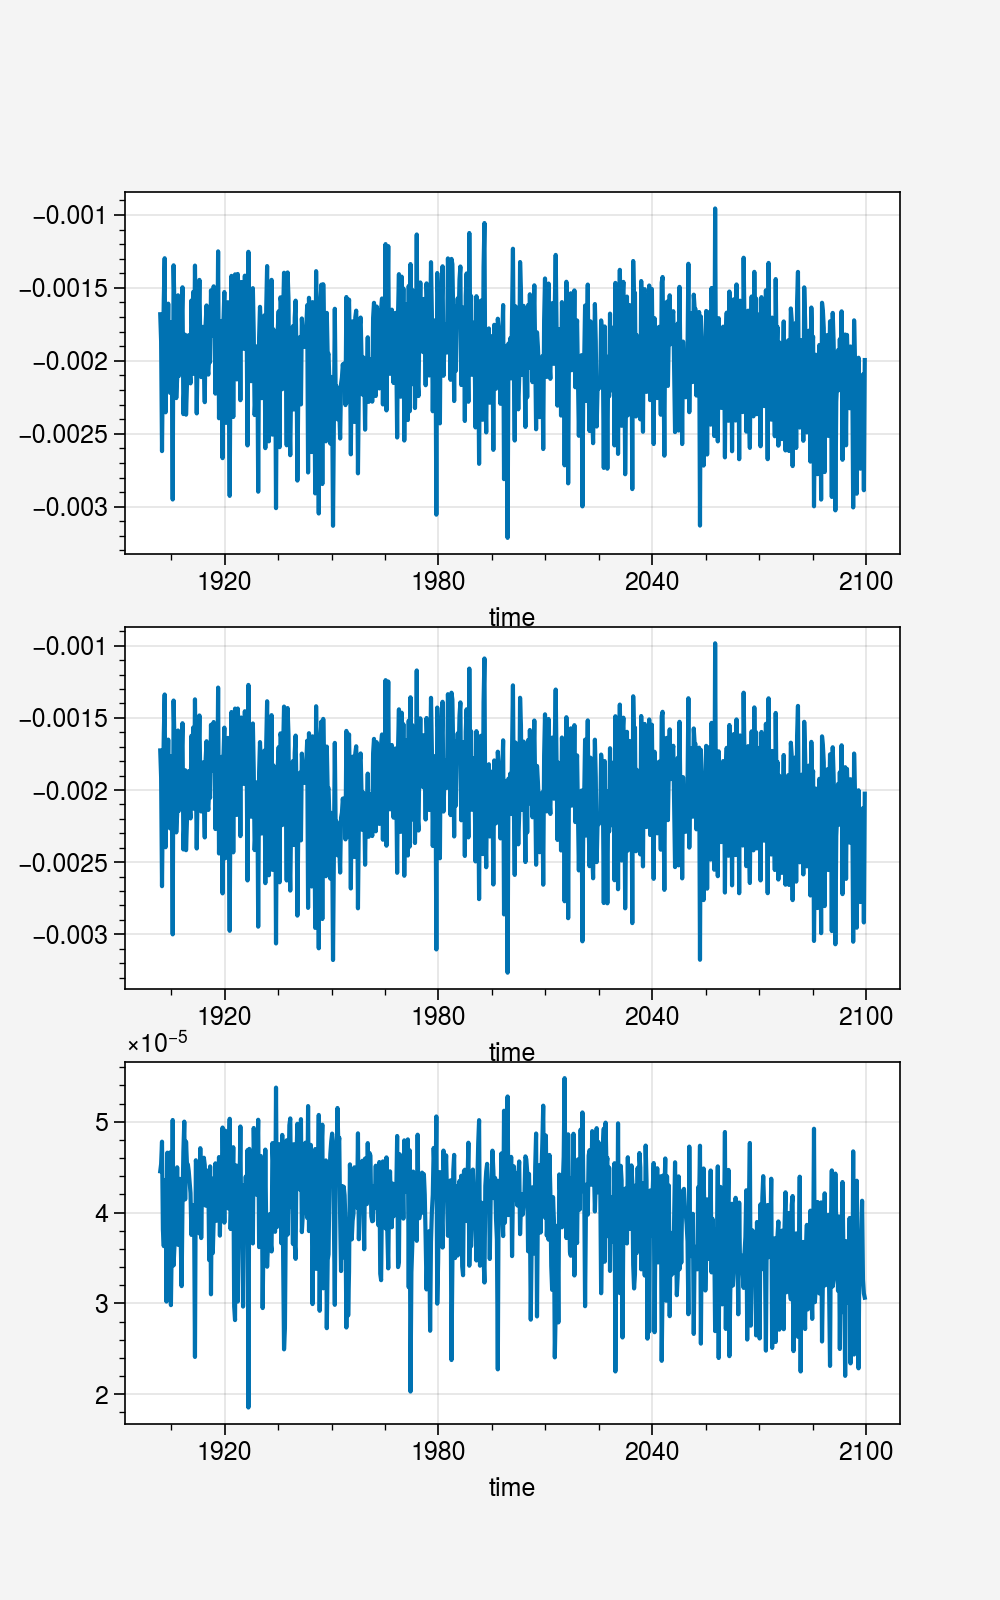

In [15]:
# --- compute total flux ---
kmt_r_TH = xds_pd_r_TH.KMT

print(xds_temp_r_TH.UET.dims)
uet_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UET, 'X')
print(uet_xintp_r_TH.dims)

print(xds_temp_r_TH.UES.dims)
ues_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UES, 'X')
print(ues_xintp_r_TH.dims)

uet_tot_tre_front_TH = uet_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time') 
# [degC/s]
ues_tot_tre_front_TH = ues_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
dzt_front_TH = xds_temp_r_TH.DZT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))

uet_tot_tre_zint_front_TH = (uet_tot_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
ues_tot_tre_zint_front_TH = (ues_tot_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
# --------------------------

# -- compute mean flow flux ---
print(xds_temp_r_TH.UVEL.dims)
uvel_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UVEL, 'X')
print(uvel_xintp_r_TH.dims)

print(uvel_xintp_r_TH.dims)
uvel_xyintp_r_TH = grid_temp_r_TH.interp(uvel_xintp_r_TH, 'Y')
uvel_xyintp_r_TH

temp_tre_front_TH = xds_temp_r_TH.TEMP.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
uvel_tre_front_TH = uvel_xyintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
salt_tre_front_TH = xds_temp_r_TH.SALT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean('time')
dxt_front_TH = xds_temp_r_TH.DXT

uet_mfl_tre_front_TH = uvel_tre_front_TH*temp_tre_front_TH/dxt_front_TH # [degC/s]
ues_mfl_tre_front_TH = uvel_tre_front_TH*salt_tre_front_TH/dxt_front_TH # 

uet_mfl_tre_zint_front_TH = (uet_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
ues_mfl_tre_zint_front_TH = (ues_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
# ----------------------------

# -- compute eddy flux ---
uet_eddy_tre_front_TH = uet_tot_tre_front_TH - uet_mfl_tre_front_TH
ues_eddy_tre_front_TH = ues_tot_tre_front_TH - ues_mfl_tre_front_TH
uet_eddy_tre_zint_front_TH = (uet_eddy_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
ues_eddy_tre_zint_front_TH = (ues_eddy_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
# ------------------------

# --- compute mass flux ---
uerho_tot_front_TH = (-2.5e-4*uet_tot_tre_zint_front_TH + 7.6e-4*ues_tot_tre_zint_front_TH).persist()
uerho_mfl_front_TH = (-2.5e-4*uet_mfl_tre_zint_front_TH + 7.6e-4*ues_mfl_tre_zint_front_TH).persist()
uerho_eddy_front_TH = (-2.5e-4*uet_eddy_tre_zint_front_TH + 7.6e-4*ues_eddy_tre_zint_front_TH).persist()
print(uerho_eddy_front_TH.dims)
print(len(uerho_tot_front_TH), len(uerho_mfl_front_TH), len(uerho_eddy_front_TH))

fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_front_TH.mean('nlat_t').plot(ax=axs[0]) # .resample(time='A').mean()
uerho_mfl_front_TH.mean('nlat_t').plot(ax=axs[1])
uerho_eddy_front_TH.mean('nlat_t').plot(ax=axs[2])
# axs[2].set_ylim([0,0.0002])

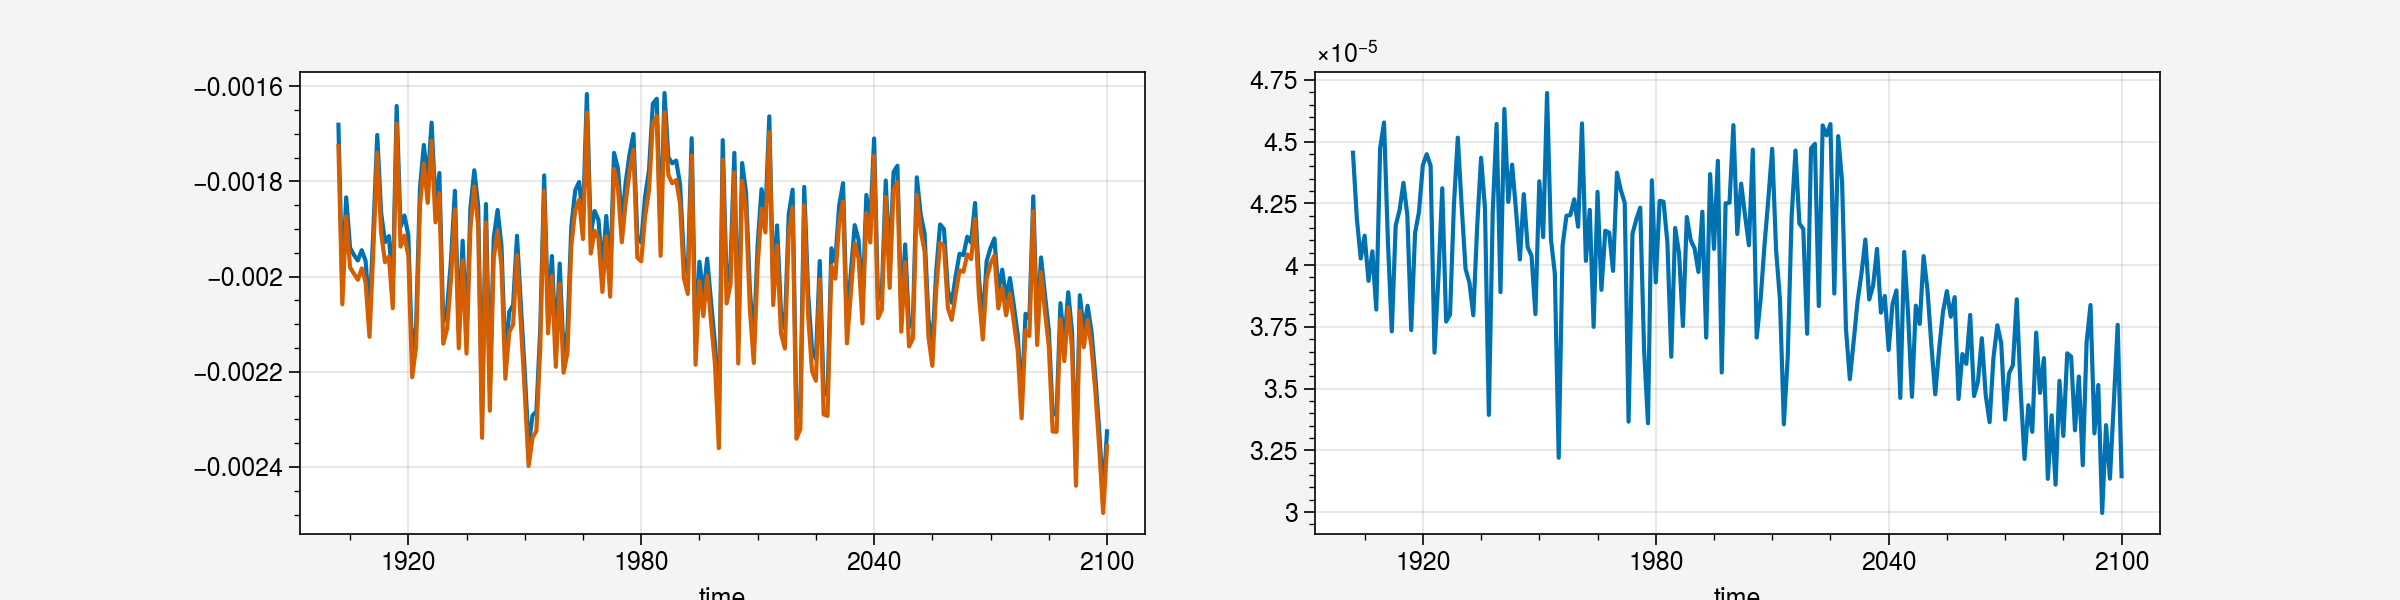

In [17]:
fig, axs = plt.subplots(1,2,figsize=(12,3))
uerho_tot_front_TH.mean('nlat_t').resample(time='A').mean('time').plot(ax=axs[0]) # .resample(time='A').mean()
uerho_mfl_front_TH.mean('nlat_t').resample(time='A').mean('time').plot(ax=axs[0])
uerho_eddy_front_TH.mean('nlat_t').resample(time='A').mean('time').plot(ax=axs[1])

('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
('time', 'z_t', 'nlat_t', 'nlon_u')
('time', 'z_t', 'nlat_t', 'nlon_t')
1901-12-31 00:00:00 2099-11-30 00:00:00 2376
1901-12-01 00:00:00 2099-09-01 00:00:00 792


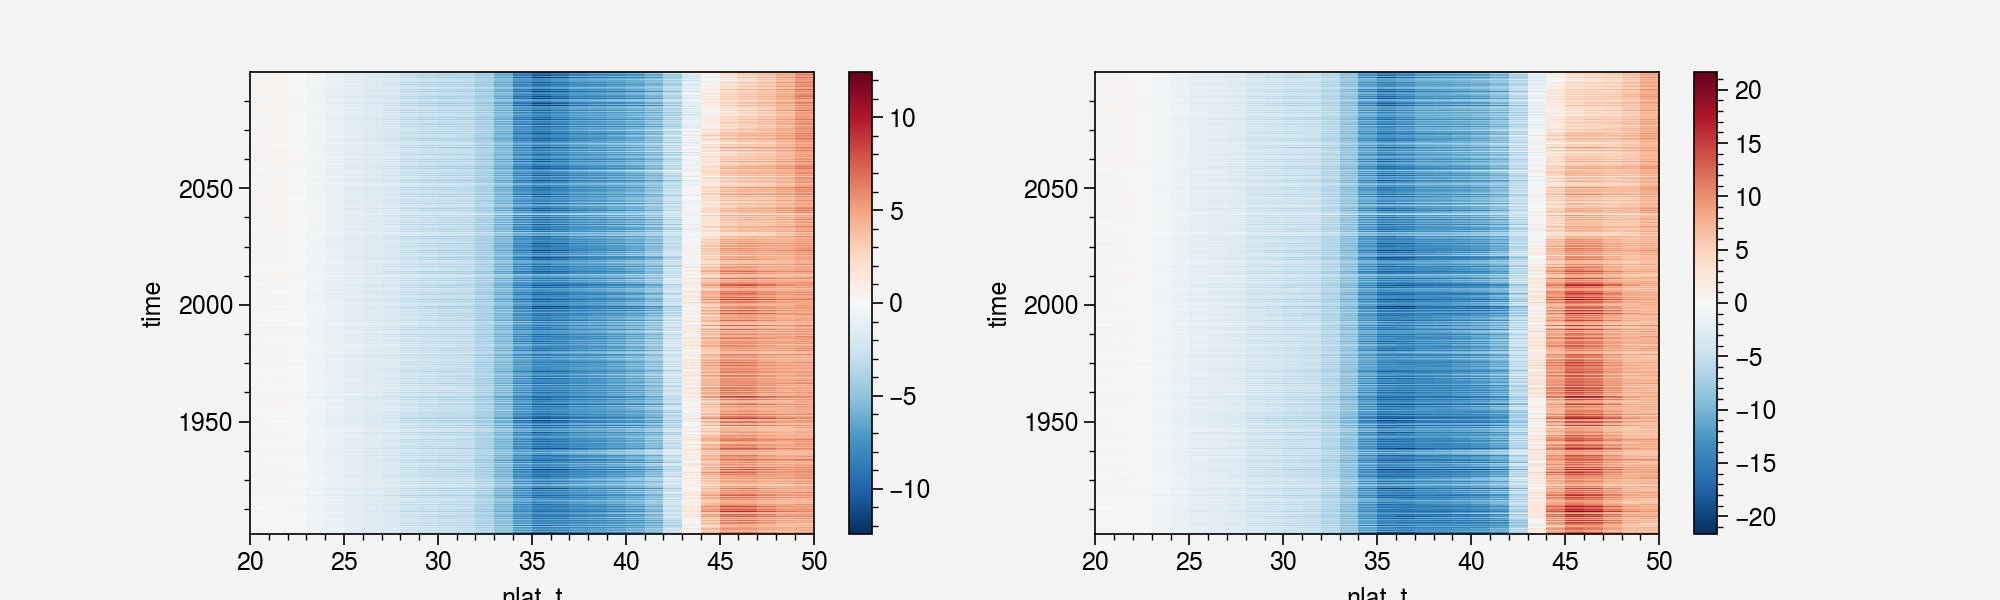

In [32]:
print(xds_temp_r_TH.UET.dims)
uet_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UET, 'X')
print(uet_xintp_r_TH.dims)

print(xds_temp_r_TH.UES.dims)
ues_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UES, 'X')
print(ues_xintp_r_TH.dims)

uet_tot_front_TH = uet_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
ues_tot_front_TH = ues_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
dzt_front_TH = xds_temp_r_TH.DZT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))

uet_tot_zint_front_TH = (uet_tot_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')
ues_tot_zint_front_TH = (ues_tot_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t')

# -- resample --
print(uet_tot_zint_front_TH.sel(time=slice('1901-12','2099-11')).time[0].values,
      uet_tot_zint_front_TH.sel(time=slice('1901-12','2099-11')).time[-1].values,
      len(uet_tot_zint_front_TH.sel(time=slice('1901-12','2099-11')).time))

uet_tot_zint_tre_front_TH = uet_tot_zint_front_TH.sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean().persist()
ues_tot_zint_tre_front_TH = ues_tot_zint_front_TH.sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean().persist()

print(uet_tot_zint_tre_front_TH.time[0].values,
      uet_tot_zint_tre_front_TH.time[-1].values,
      len(uet_tot_zint_tre_front_TH.time))
# --------------

fig, axs = plt.subplots(1,2,figsize=(10,3))
uet_tot_zint_tre_front_TH.plot(ax=axs[0])
ues_tot_zint_tre_front_TH.plot(ax=axs[1])

('time', 'z_t', 'nlat_u', 'nlon_u')
('time', 'z_t', 'nlat_u', 'nlon_t')
('time', 'z_t', 'nlat_u', 'nlon_t')
1901-12-01 00:00:00 2099-09-01 00:00:00 792


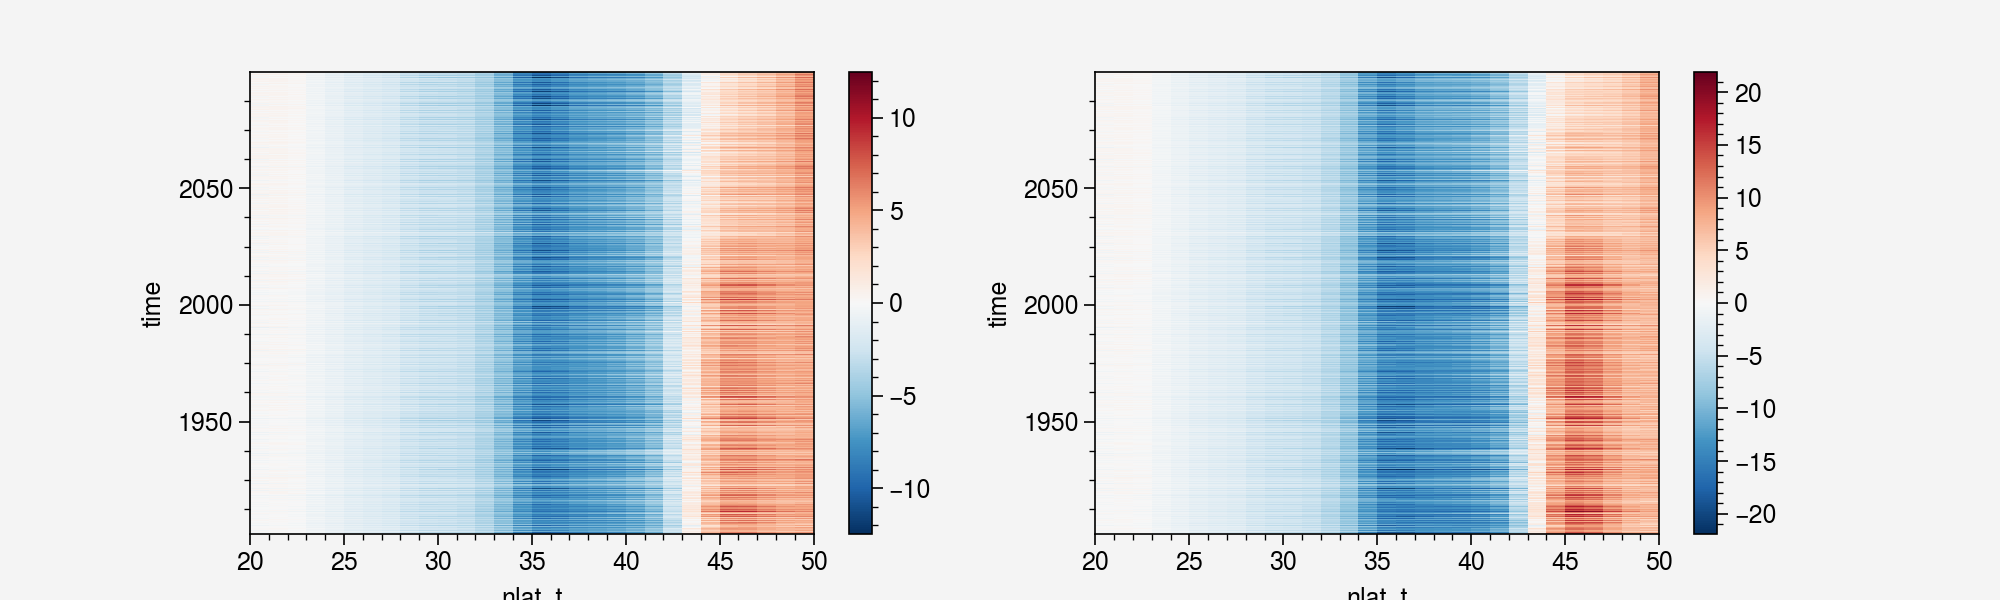

In [34]:
print(xds_temp_r_TH.UVEL.dims)
uvel_xintp_r_TH = grid_temp_r_TH.interp(xds_temp_r_TH.UVEL, 'X')
print(uvel_xintp_r_TH.dims)

print(uvel_xintp_r_TH.dims)
uvel_xyintp_r_TH = grid_temp_r_TH.interp(uvel_xintp_r_TH, 'Y')
uvel_xyintp_r_TH

temp_tre_front_TH = xds_temp_r_TH.TEMP.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean()
uvel_tre_front_TH = uvel_xyintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean()
salt_tre_front_TH = xds_temp_r_TH.SALT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50)).sel(time=slice('1901-12','2099-11')).resample(time='QS-DEC').mean()
dxt_front_TH = xds_temp_r_TH.DXT

uet_mfl_tre_front_TH = uvel_tre_front_TH*temp_tre_front_TH/dxt_front_TH
ues_mfl_tre_front_TH = uvel_tre_front_TH*salt_tre_front_TH/dxt_front_TH
ues_mfl_tre_front_TH

uet_mfl_zint_tre_front_TH = (uet_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()
ues_mfl_zint_tre_front_TH = (ues_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()

print(uet_mfl_zint_tre_front_TH.time[0].values,
      uet_mfl_zint_tre_front_TH.time[-1].values,
      len(uet_mfl_zint_tre_front_TH.time))

fig, axs = plt.subplots(1,2,figsize=(10,3))
uet_mfl_zint_tre_front_TH.plot(ax=axs[0])
ues_mfl_zint_tre_front_TH.plot(ax=axs[1])

('time', 'nlat_t')
792 792 792


(0.0, 0.0002)

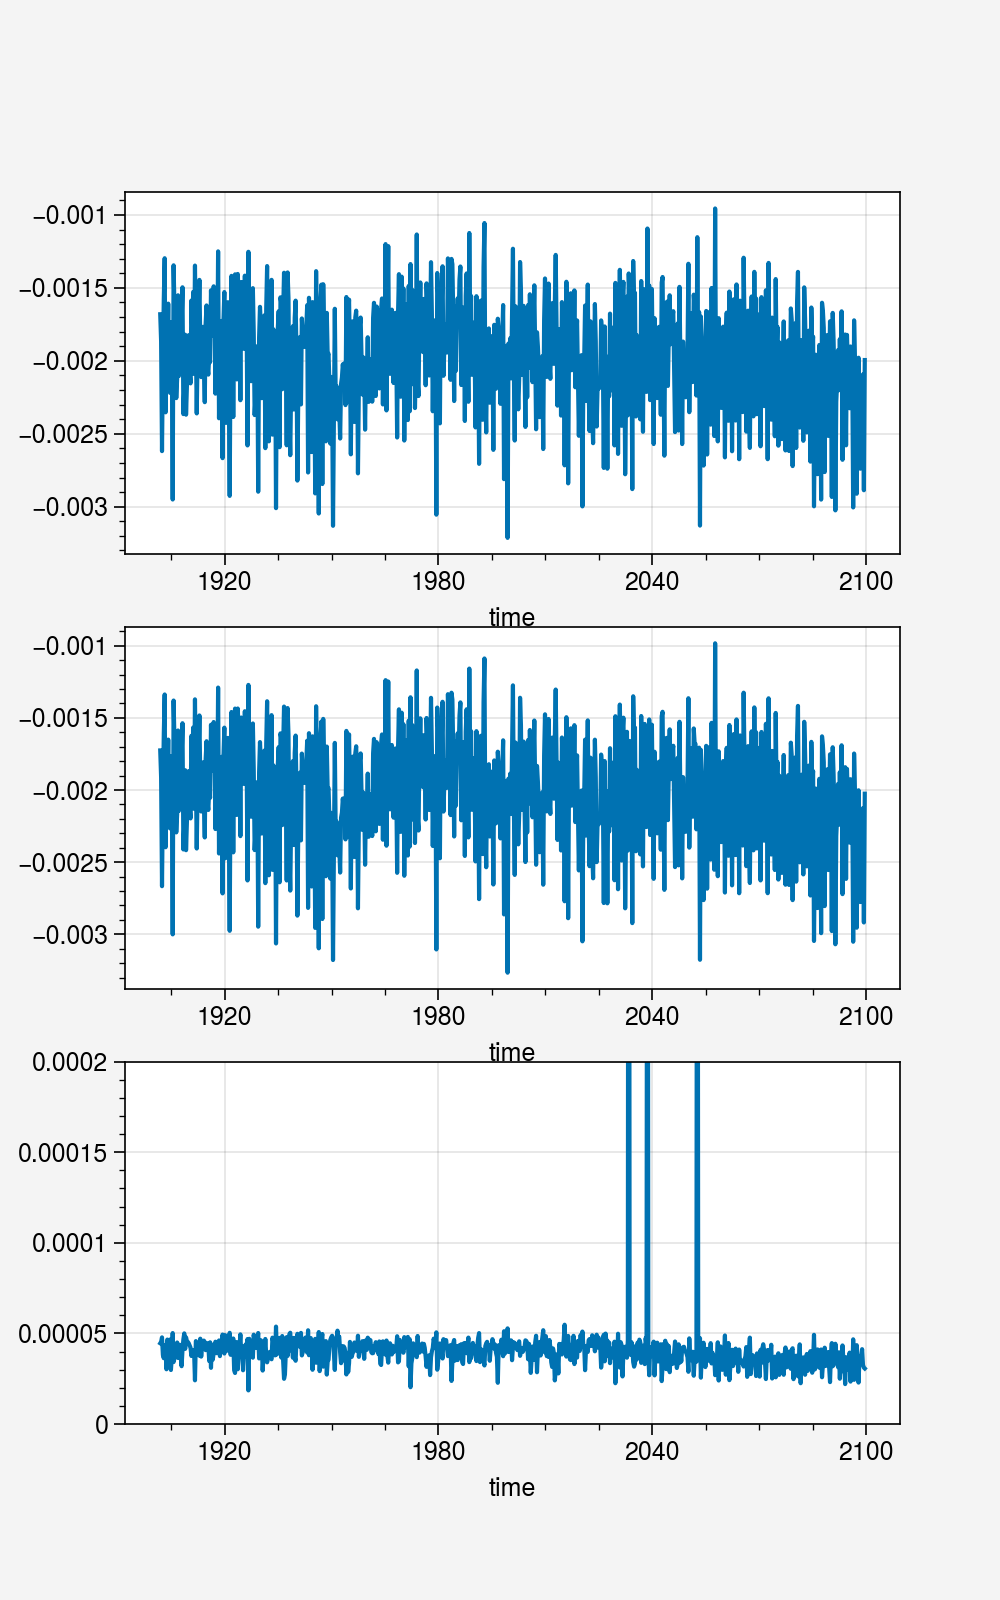

In [38]:
uerho_tot_front_TH = -2.5e-4*uet_tot_zint_tre_front_TH + 7.6e-4*ues_tot_zint_tre_front_TH
uerho_mfl_front_TH = -2.5e-4*uet_mfl_zint_tre_front_TH + 7.6e-4*ues_mfl_zint_tre_front_TH
uerho_eddy_front_TH = uerho_tot_front_TH - uerho_mfl_front_TH 
print(uerho_eddy_front_TH.dims)
print(len(uerho_tot_front_TH), len(uerho_mfl_front_TH), len(uerho_eddy_front_TH))

fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_front_TH.mean('nlat_t').plot(ax=axs[0]) # .resample(time='A').mean()
uerho_mfl_front_TH.mean('nlat_t').plot(ax=axs[1])
uerho_eddy_front_TH.mean('nlat_t').plot(ax=axs[2])
axs[2].set_ylim([0,0.0002])

1899-12-01 00:00:00 2100-12-01 00:00:00 805
1899-12-01 00:00:00 2100-12-01 00:00:00 805


NameError: name 'uet_mfl_zint_front_TH' is not defined

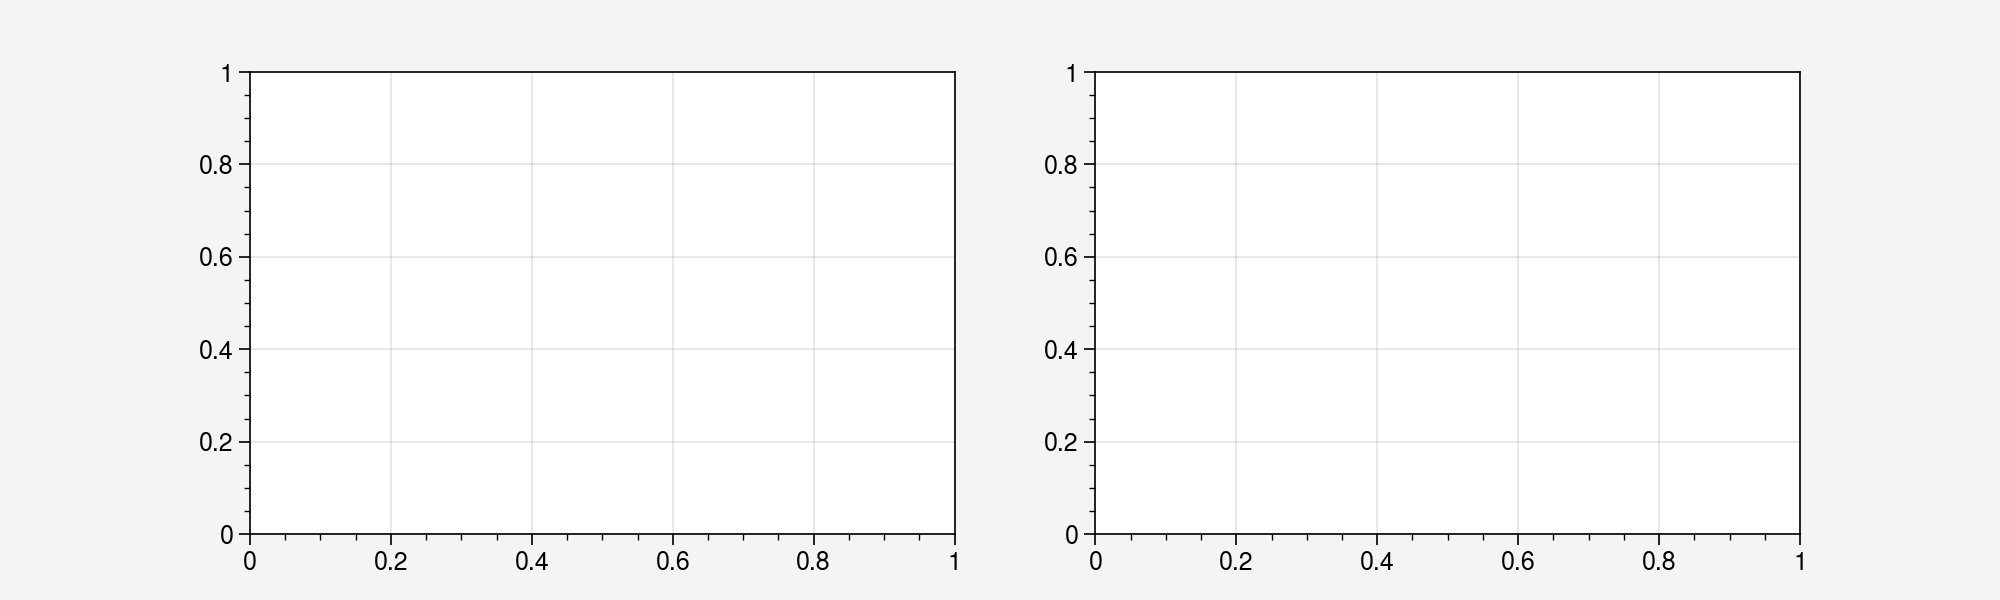

In [19]:
# 2022Jan29 
uet_xintp_front_TH = uet_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
ues_xintp_front_TH = ues_xintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
dzt_front_TH = xds_temp_r_TH.DZT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))

temp_front_TH = xds_temp_r_TH.TEMP.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
uvel_front_TH = uvel_xyintp_r_TH.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
salt_front_TH = xds_temp_r_TH.SALT.sel(nlon_t=slice(19, 22),nlat_t=slice(20,50))
dxt_front_TH = xds_temp_r_TH.DXT

uvel_tre_front_TH = uvel_front_TH.resample(time="QS-DEC").mean().persist()
temp_tre_front_TH = temp_front_TH.resample(time="QS-DEC").mean().persist()
salt_tre_front_TH = salt_front_TH.resample(time="QS-DEC").mean().persist()
uet_xintp_tre_front_TH = uet_xintp_front_TH.resample(time="QS-DEC").mean().persist()
ues_xintp_tre_front_TH = ues_xintp_front_TH.resample(time="QS-DEC").mean().persist()
print(uvel_tre_front_TH.time[0].values, uvel_tre_front_TH.time[-1].values, len(uvel_tre_front_TH.time))

uet_mfl_tre_front_TH = uvel_tre_front_TH*temp_tre_front_TH/dxt_front_TH
ues_mfl_tre_front_TH = uvel_tre_front_TH*salt_tre_front_TH/dxt_front_TH
print(uet_mfl_tre_front_TH.time[0].values, uet_mfl_tre_front_TH.time[-1].values, len(uet_mfl_tre_front_TH.time))

uet_mfl_tre_zint_front_TH = (uet_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()
ues_mfl_tre_zint_front_TH = (ues_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()

uet_xintp_tre_zint_front_TH = (uet_xintp_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()
ues_xintp_tre_zint_front_TH = (ues_xintp_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()

fig, axs = plt.subplots(1,2,figsize=(10,3))
uet_mfl_zint_front_TH.plot(ax=axs[0])
ues_mfl_zint_front_TH.plot(ax=axs[1])

('time', 'nlat_t')


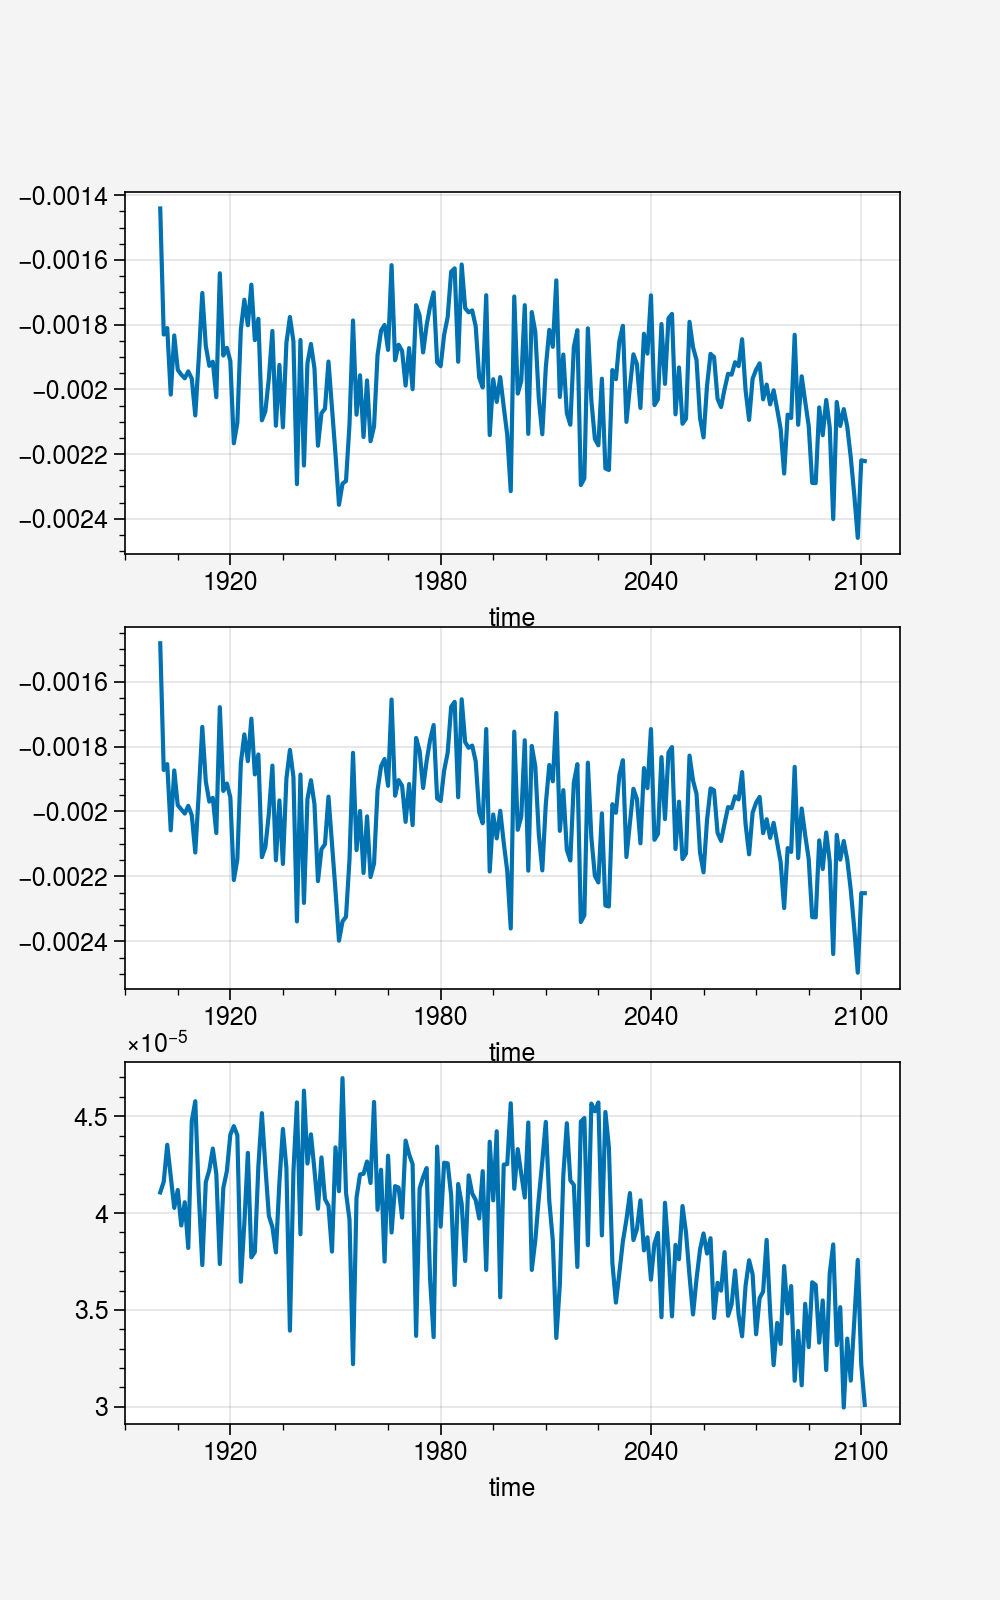

In [20]:
# 2022Jan29
uerho_tot_front_TH = -2.5e-4*uet_xintp_tre_zint_front_TH + 7.6e-4*ues_xintp_tre_zint_front_TH
uerho_mfl_front_TH = -2.5e-4*uet_mfl_tre_zint_front_TH + 7.6e-4*ues_mfl_tre_zint_front_TH
uerho_eddy_front_TH = uerho_tot_front_TH - uerho_mfl_front_TH 
print(uerho_eddy_front_TH.dims)

fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[0])
uerho_mfl_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[1])
uerho_eddy_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[2])

1899-12-01 00:00:00 2100-12-01 00:00:00 805
1899-12-01 00:00:00 2100-12-01 00:00:00 805


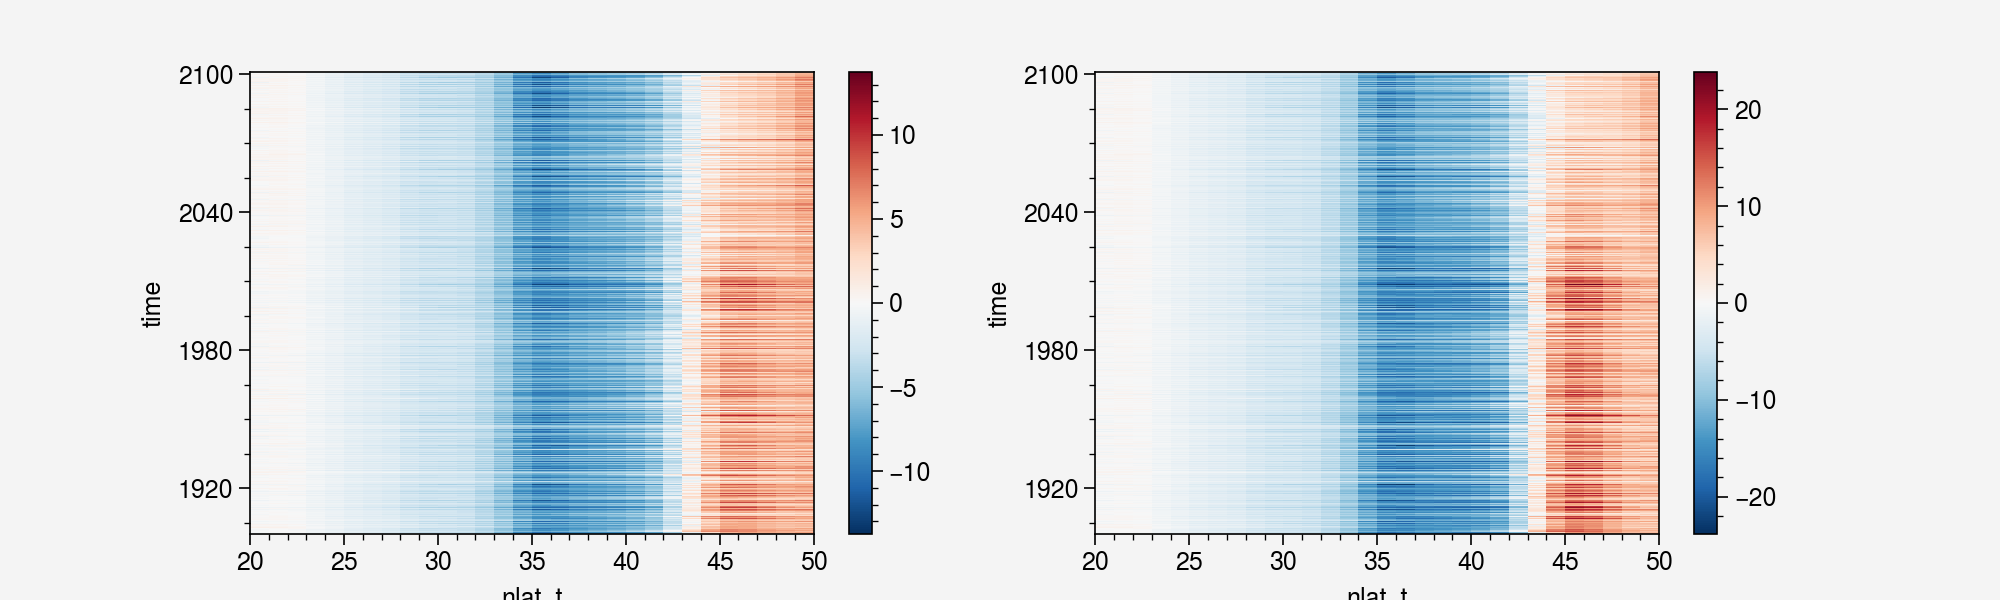

In [47]:
# # 2022Jan29 
# uvel_tre_front_TH = uvel_front_TH.resample(time="QS-DEC").mean().persist()
# temp_tre_front_TH = temp_front_TH.resample(time="QS-DEC").mean().persist()
# salt_tre_front_TH = salt_front_TH.resample(time="QS-DEC").mean().persist()
# uet_xintp_tre_front_TH = uet_xintp_front_TH.resample(time="QS-DEC").mean().persist()
# ues_xintp_tre_front_TH = ues_xintp_front_TH.resample(time="QS-DEC").mean().persist()
# print(uvel_tre_front_TH.time[0].values, uvel_tre_front_TH.time[-1].values, len(uvel_tre_front_TH.time))

# uet_mfl_tre_front_TH = uvel_tre_front_TH*temp_tre_front_TH/dxt_front_TH
# ues_mfl_tre_front_TH = uvel_tre_front_TH*salt_tre_front_TH/dxt_front_TH
# print(uet_mfl_tre_front_TH.time[0].values, uet_mfl_tre_front_TH.time[-1].values, len(uet_mfl_tre_front_TH.time))

# uet_mfl_tre_zint_front_TH = (uet_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()
# ues_mfl_tre_zint_front_TH = (ues_mfl_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()

# uet_xintp_tre_zint_front_TH = (uet_xintp_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()
# ues_xintp_tre_zint_front_TH = (ues_xintp_tre_front_TH*dzt_front_TH).sum('z_t').mean('nlon_t').persist()

# fig, axs = plt.subplots(1,2,figsize=(10,3))
# uet_mfl_zint_front_TH.plot(ax=axs[0])
# ues_mfl_zint_front_TH.plot(ax=axs[1])

('time', 'nlat_t')


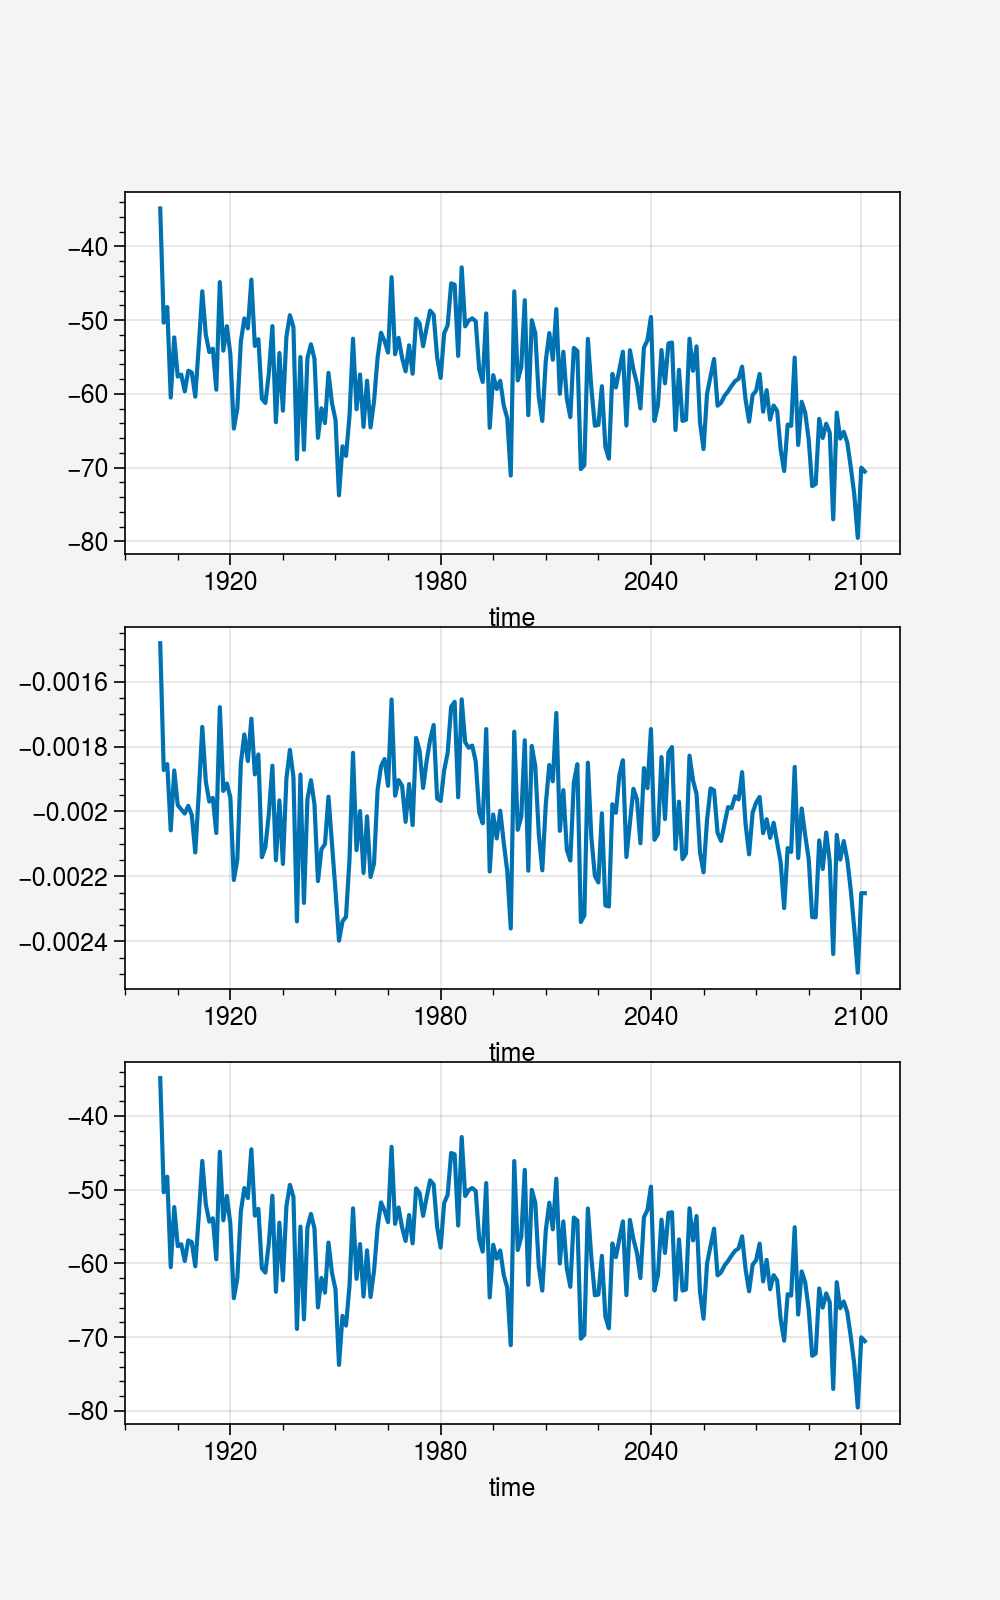

In [50]:
# 2022Jan29
uerho_tot_front_TH = -2.5e-4*uet_xintp_tre_zint_front_TH + 7.6e-4*ues_xintp_tre_zint_front_TH
uerho_mfl_front_TH = -2.5e-4*uet_mfl_tre_zint_front_TH + 7.6e-4*ues_mfl_tre_zint_front_TH
uerho_eddy_front_TH = uerho_tot_front_TH - uerho_mfl_front_TH 
print(uerho_eddy_front_TH.dims)

fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_tot_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[0])
uerho_mfl_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[1])
uerho_eddy_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[2])

1900-01-31 00:00:00 2100-12-31 00:00:00 2412


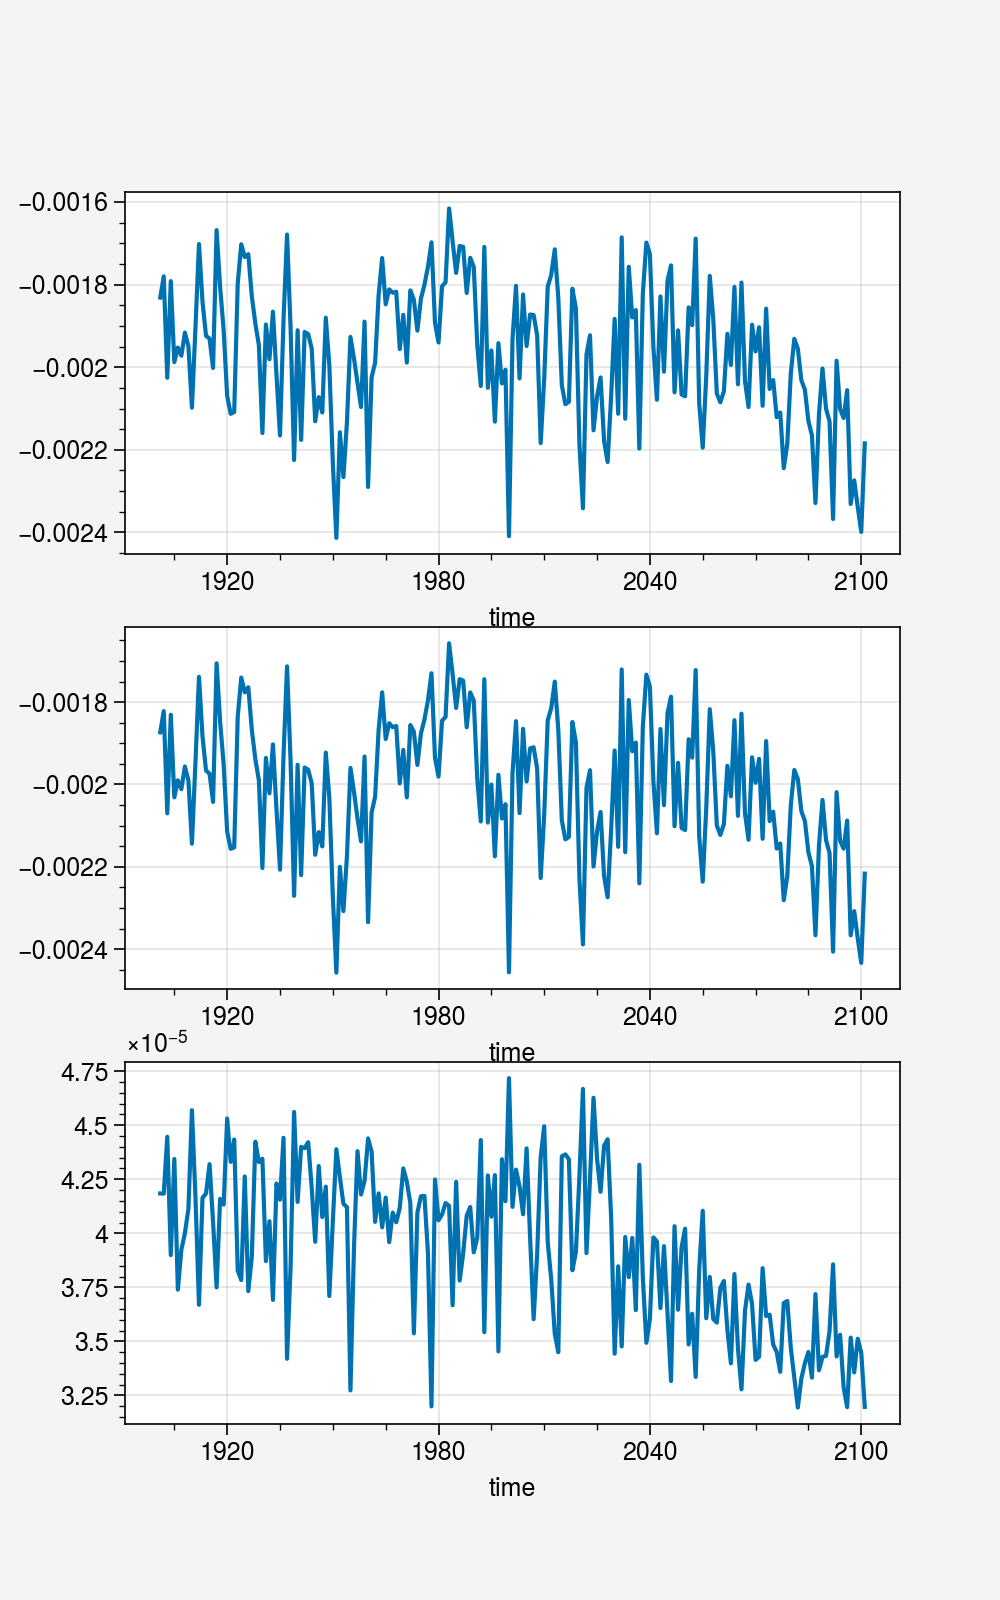

In [42]:
uerho_front_TH = -2.5e-4*uet_xintp_front_TH + 7.6e-4*ues_xintp_front_TH
uerho_mfl_front_TH = -2.5e-4*uet_mfl_zint_front_TH + 7.6e-4*ues_mfl_zint_front_TH
uerho_eddy_front_TH = uerho_front_TH - uerho_mfl_front_TH  
print(uerho_eddy_front_TH.time[0].values, uerho_eddy_front_TH.time[-1].values, len(uerho_eddy_front_TH.time))
# uerho_front_TH.plot()
fig, axs = plt.subplots(3,1,figsize=(5,8))
uerho_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[0])
uerho_mfl_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[1])
uerho_eddy_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[2])

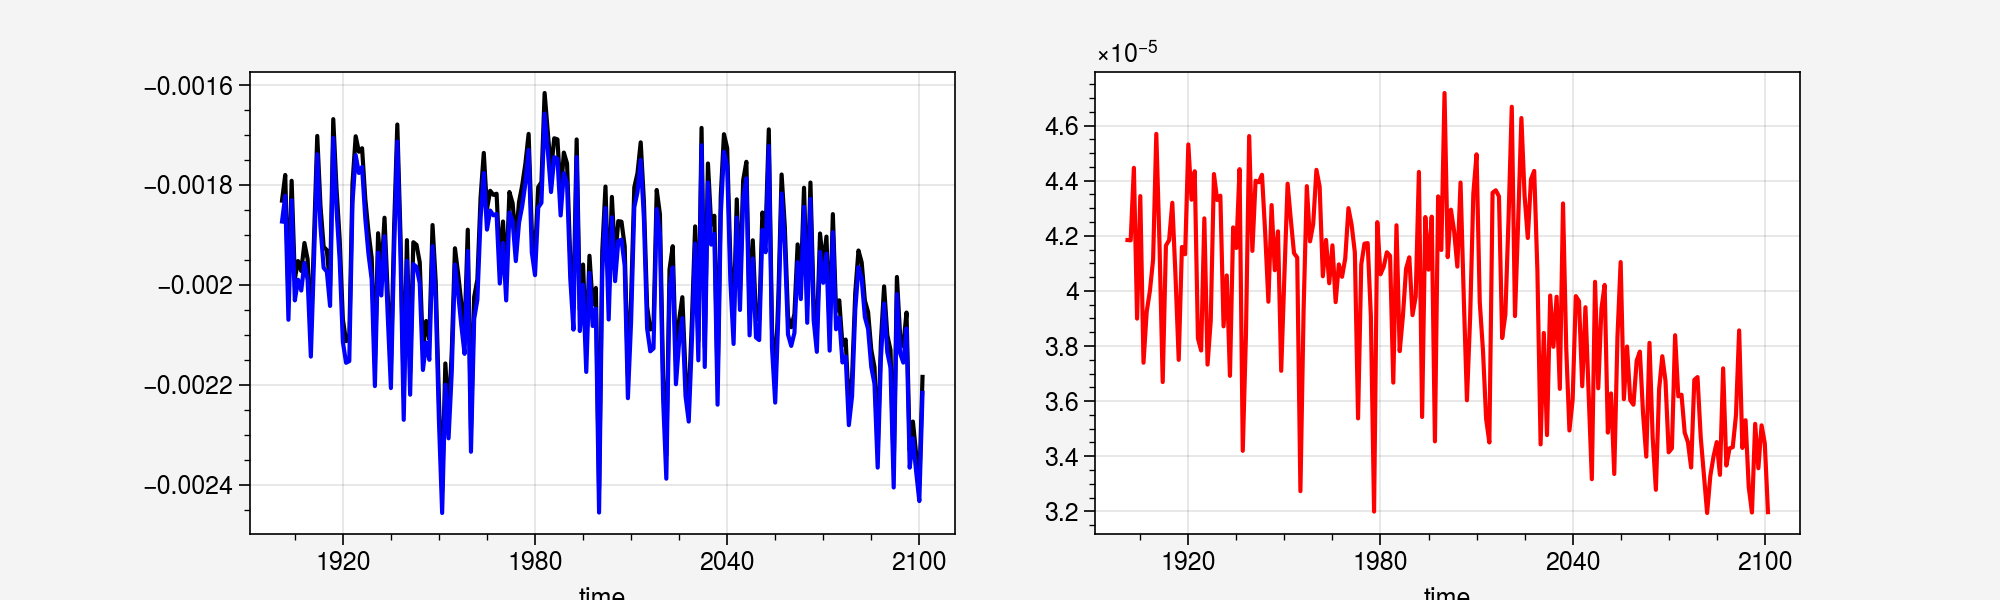

In [43]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
uerho_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[0], color='k')
uerho_mfl_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[0], color='b')
uerho_eddy_front_TH.mean('nlat_t').resample(time='A').mean().plot(ax=axs[1], color='r')

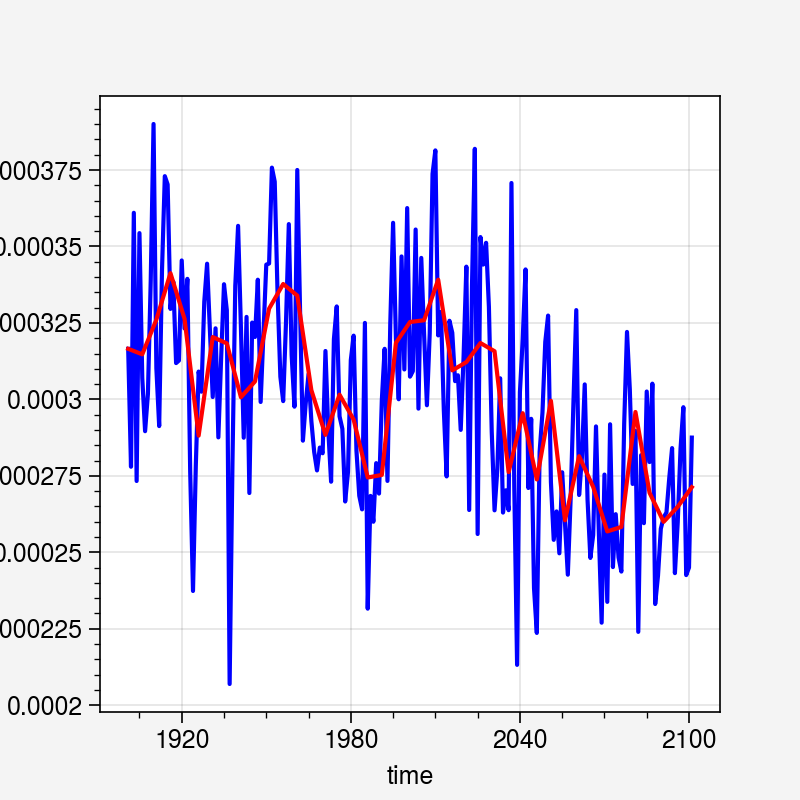

In [19]:
uerho_front_TH.mean('nlat_t').resample(time='A').mean().plot(color='b')
uerho_front_TH.mean('nlat_t').resample(time='5A').mean().plot(color='r')

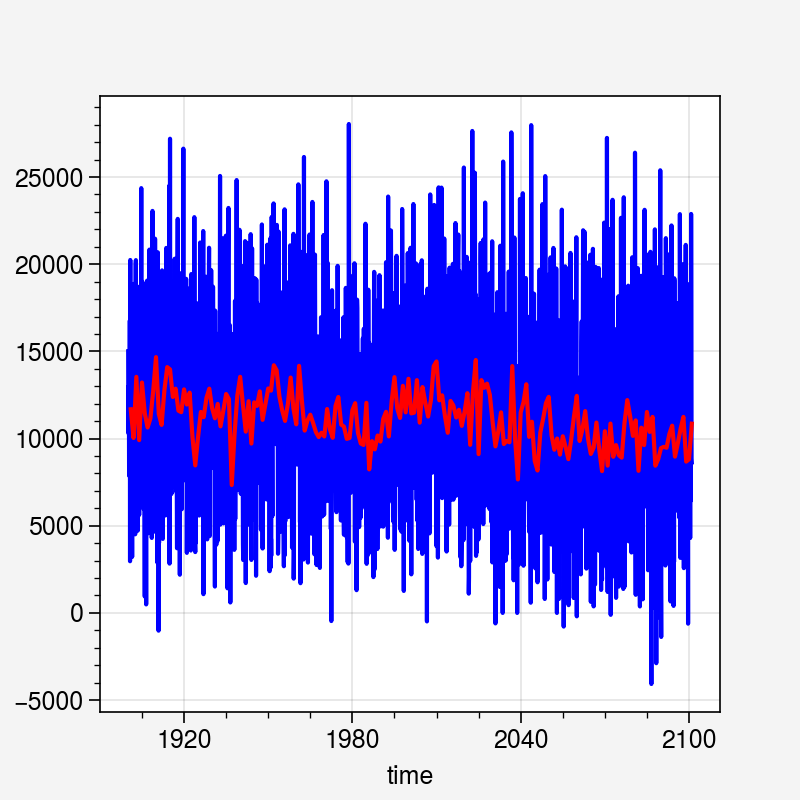

In [39]:
uvel_mfl_front_TH = (uvel_front_TH*dzt_front_TH).sum('z_t').mean(('nlon_t','nlat_t')).persist()
uvel_mfl_front_TH.plot(color='b')
uvel_mfl_front_TH.resample(time='A').mean('time').plot(color='r')

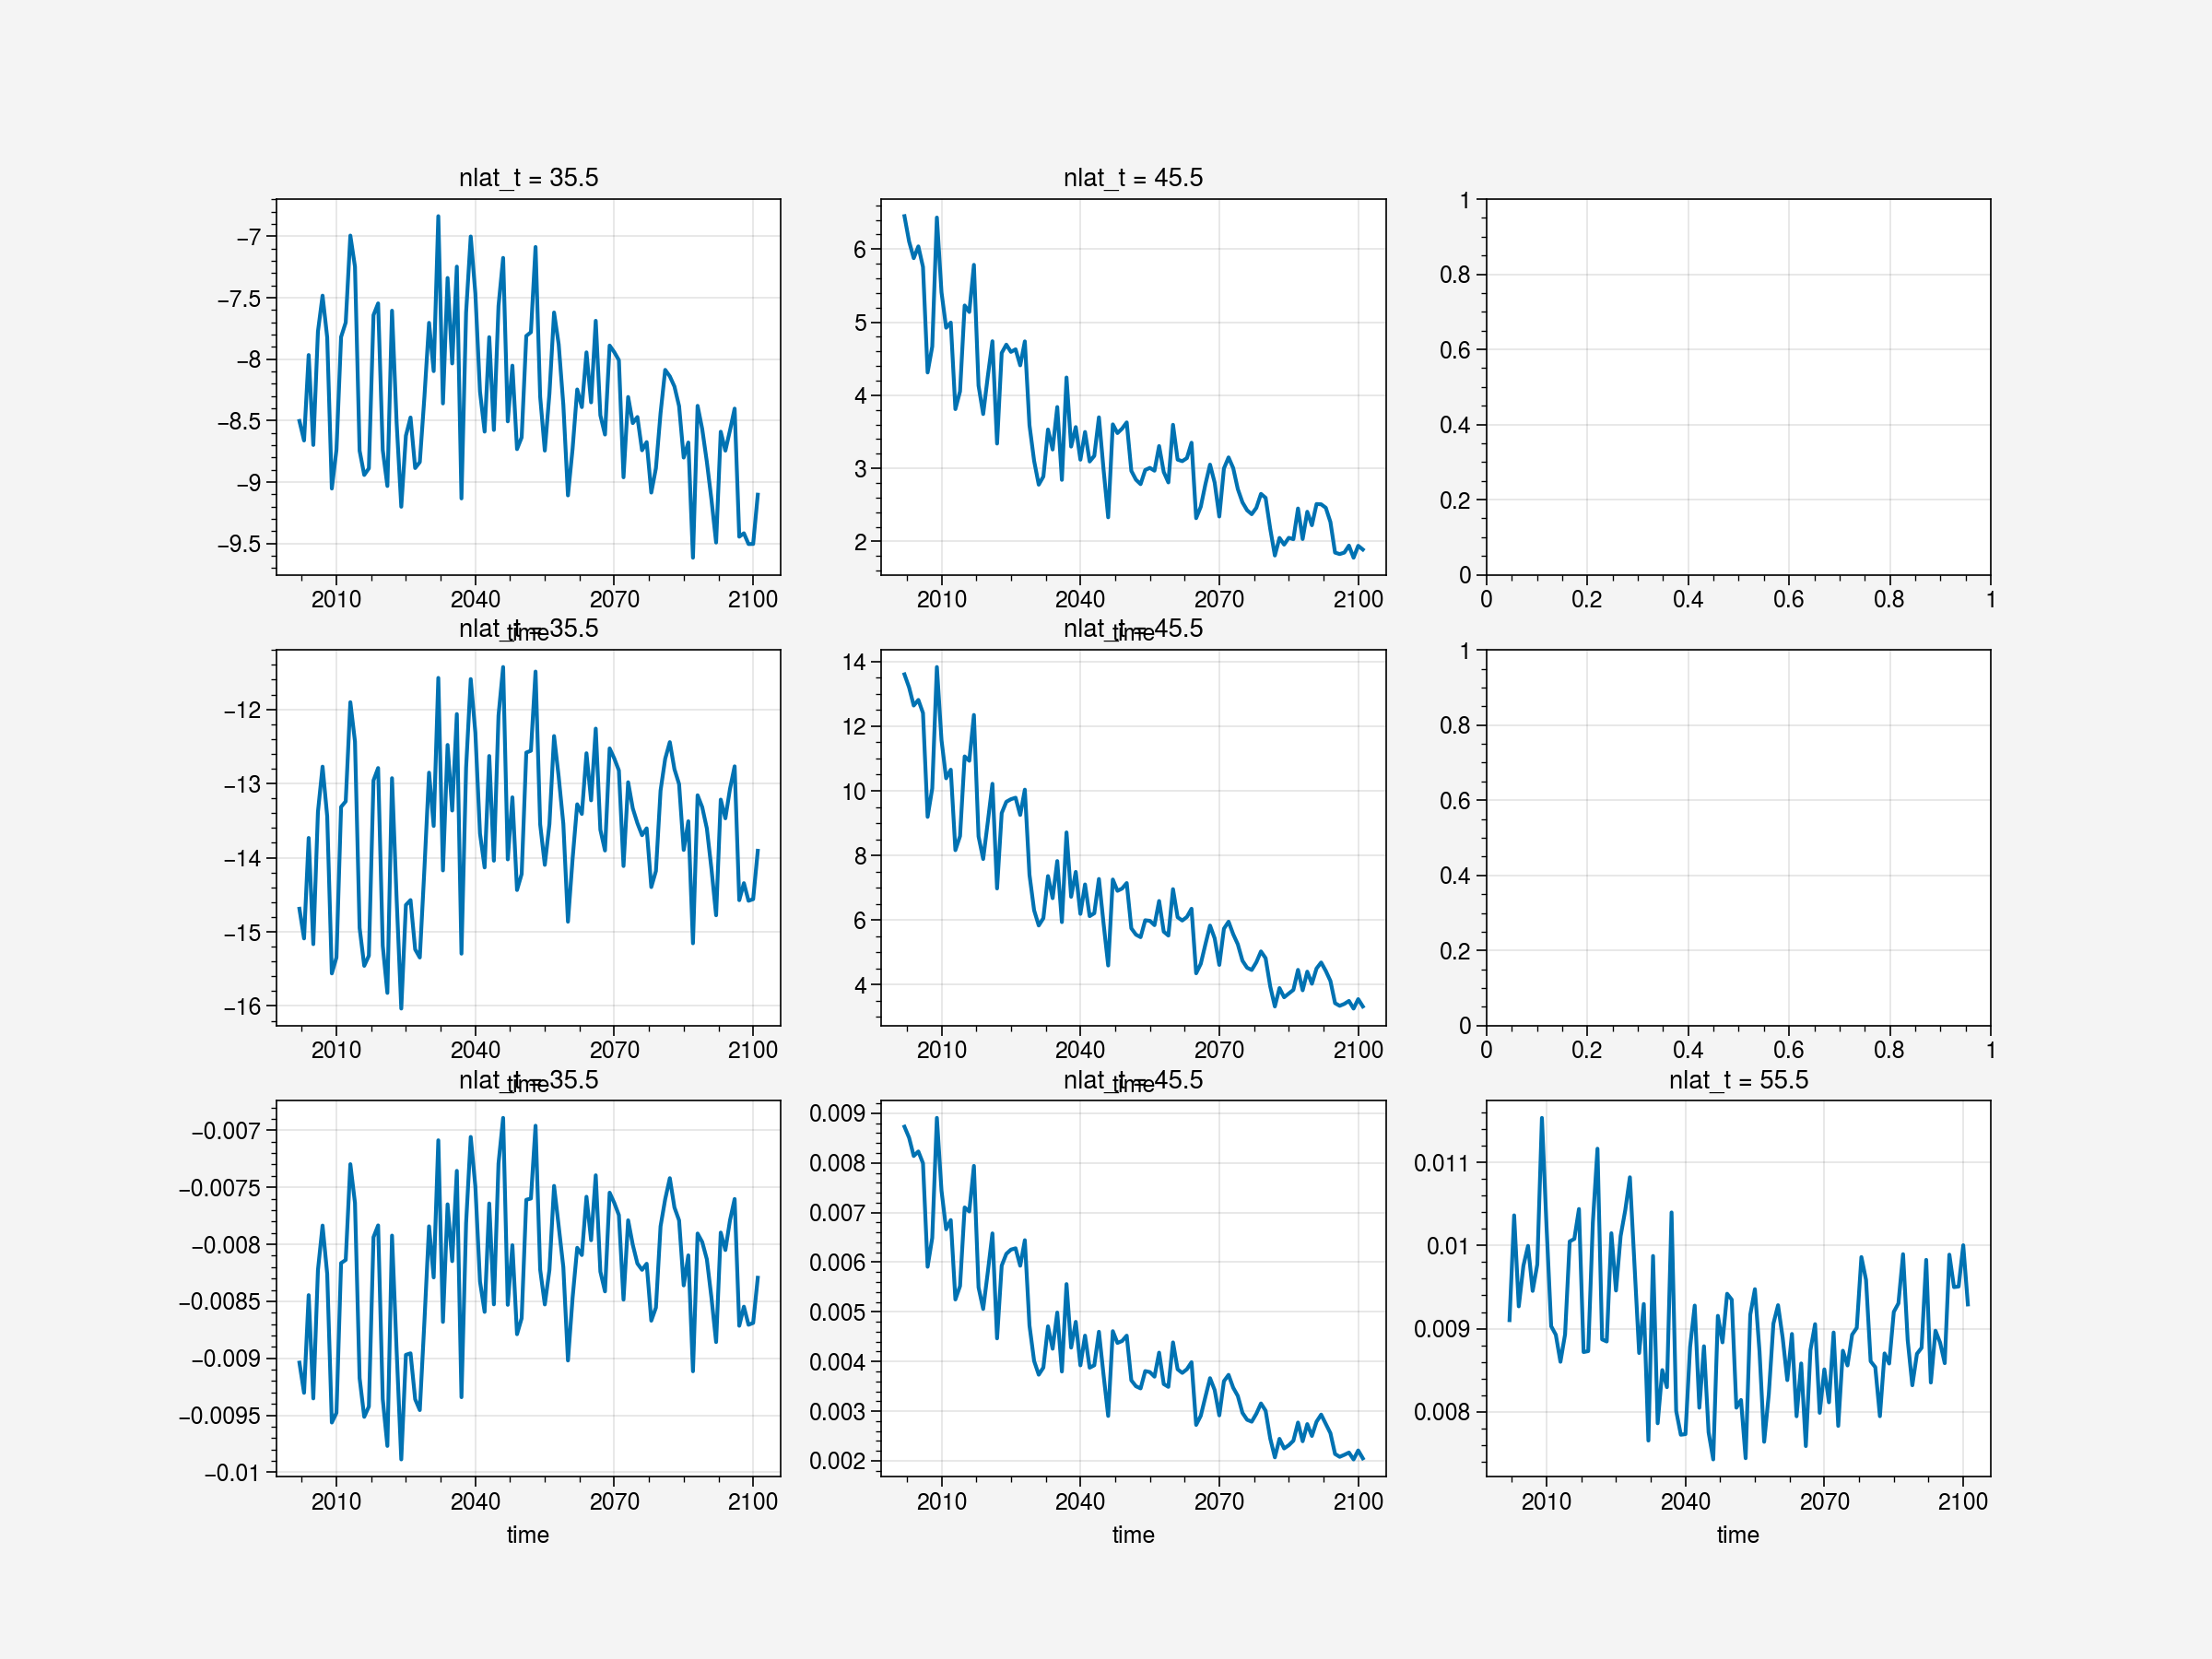

In [25]:
fig, axs = plt.subplots(3,3,figsize=(12,9))
uet_xintp_front_TH.sel(nlat_t=35.5).resample(time='A').mean().plot(ax=axs[0,0])
uet_xintp_front_TH.sel(nlat_t=45.5).resample(time='A').mean().plot(ax=axs[0,1])
ues_xintp_front_TH.sel(nlat_t=35.5).resample(time='A').mean().plot(ax=axs[1,0])
ues_xintp_front_TH.sel(nlat_t=45.5).resample(time='A').mean().plot(ax=axs[1,1])
uerho_front_TH.sel(nlat_t=35.5).resample(time='A').mean().plot(ax=axs[2,0])
uerho_front_TH.sel(nlat_t=45.5).resample(time='A').mean().plot(ax=axs[2,1])
uerho_front_TH.sel(nlat_t=55.5).resample(time='A').mean().plot(ax=axs[2,2])

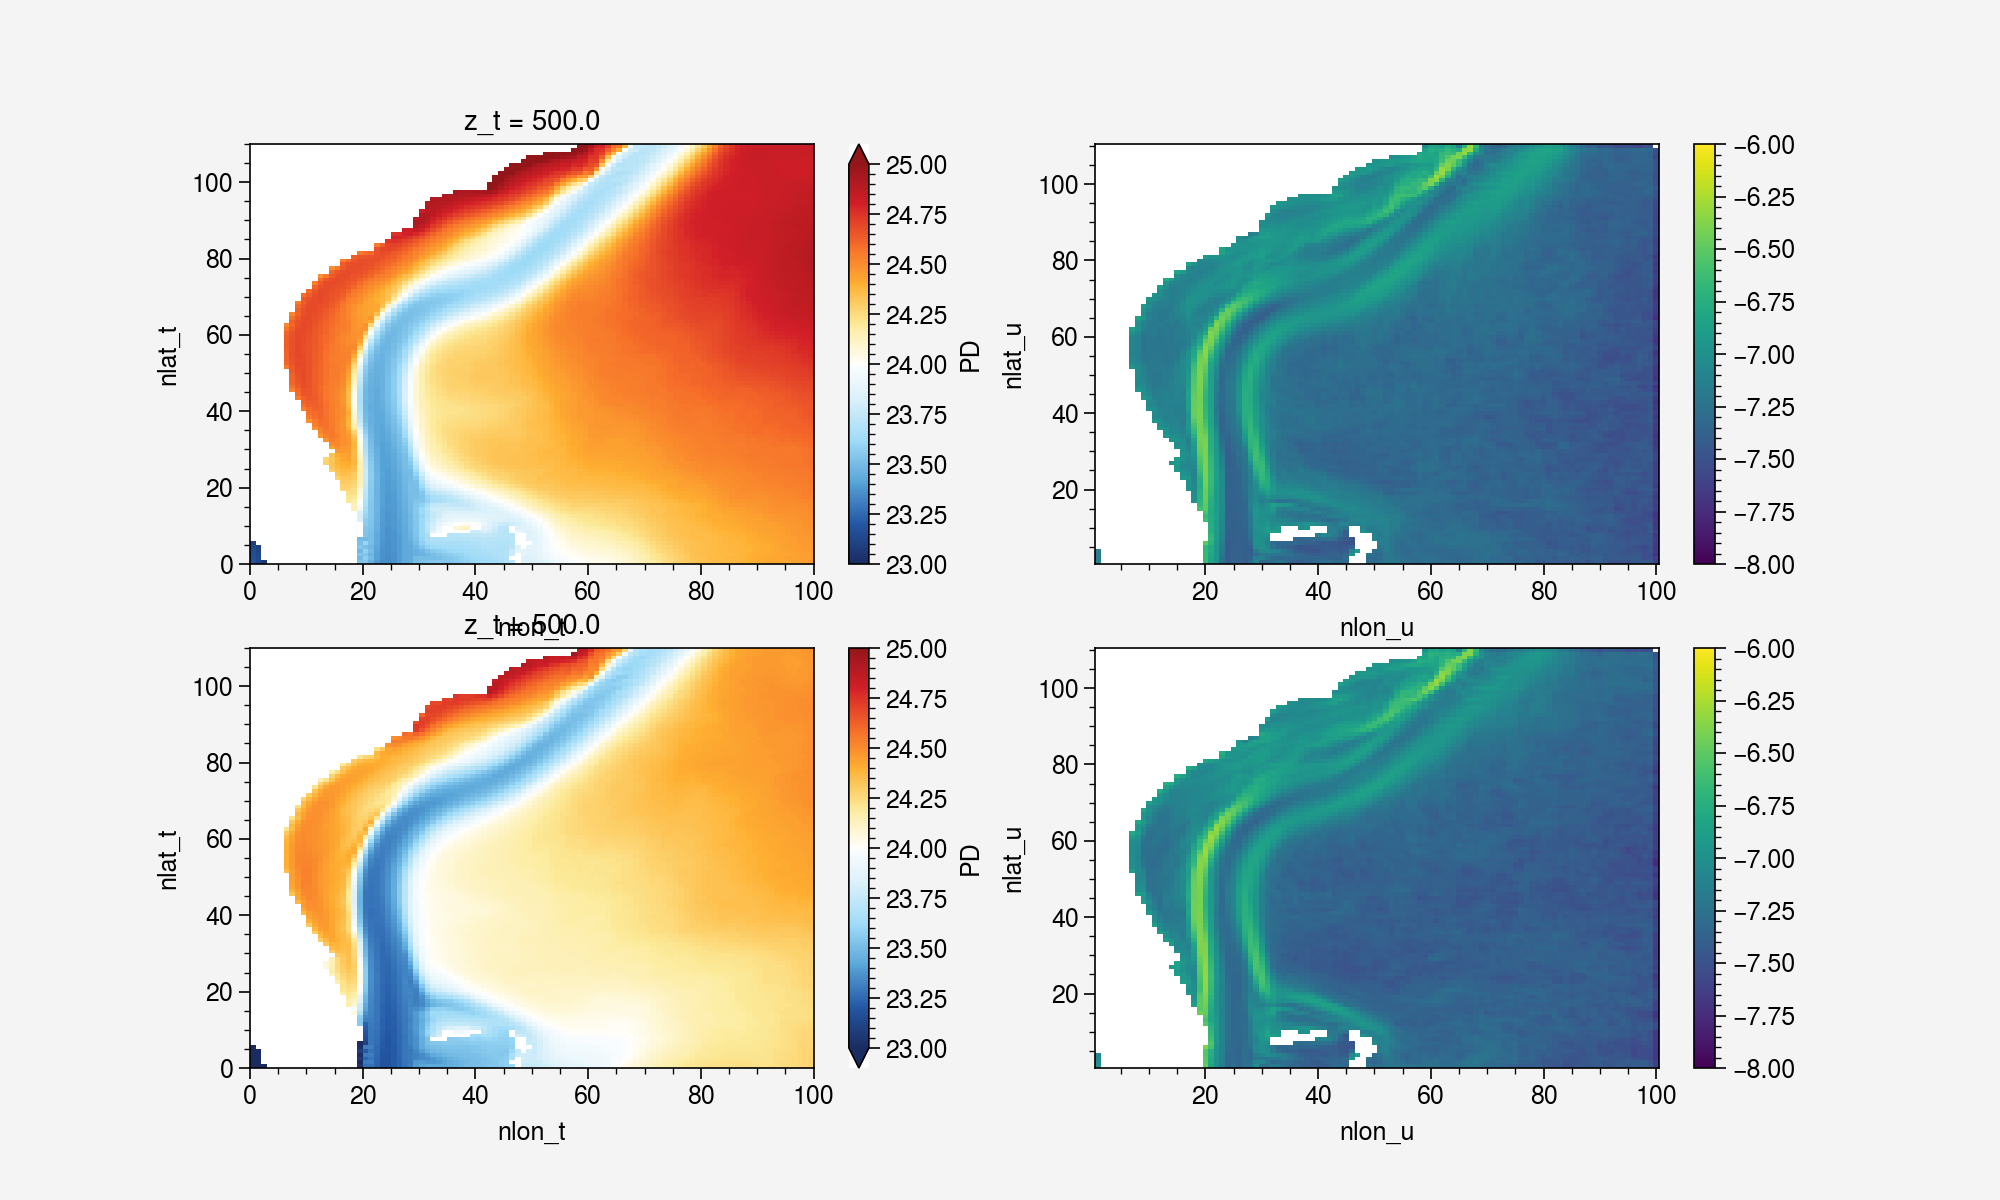

In [18]:
pd_z_rm_t1av_TH = pd_z_rm_TH.sel(time=slice('2001','2020')).mean('time')
grad_pd_amp_t1av_TH = grad_pd_amp_TH.sel(time=slice('2001','2020')).mean('time')
pd_z_rm_t2av_TH = pd_z_rm_TH.sel(time=slice('2081','2100')).mean('time')
grad_pd_amp_t2av_TH = grad_pd_amp_TH.sel(time=slice('2081','2100')).mean('time')

fig, axs = plt.subplots(2,2, figsize=(10,6))
pd_z_rm_t1av_TH.plot(ax=axs[0,0],vmin=23,vmax=25, cmap='ColdHot')
np.log10(grad_pd_amp_t1av_TH).plot(ax=axs[0,1],vmin=-8, vmax=-6, cmap='viridis')
pd_z_rm_t2av_TH.plot(ax=axs[1,0],vmin=23,vmax=25, cmap='ColdHot')
np.log10(grad_pd_amp_t2av_TH).plot(ax=axs[1,1],vmin=-8, vmax=-6, cmap='viridis')

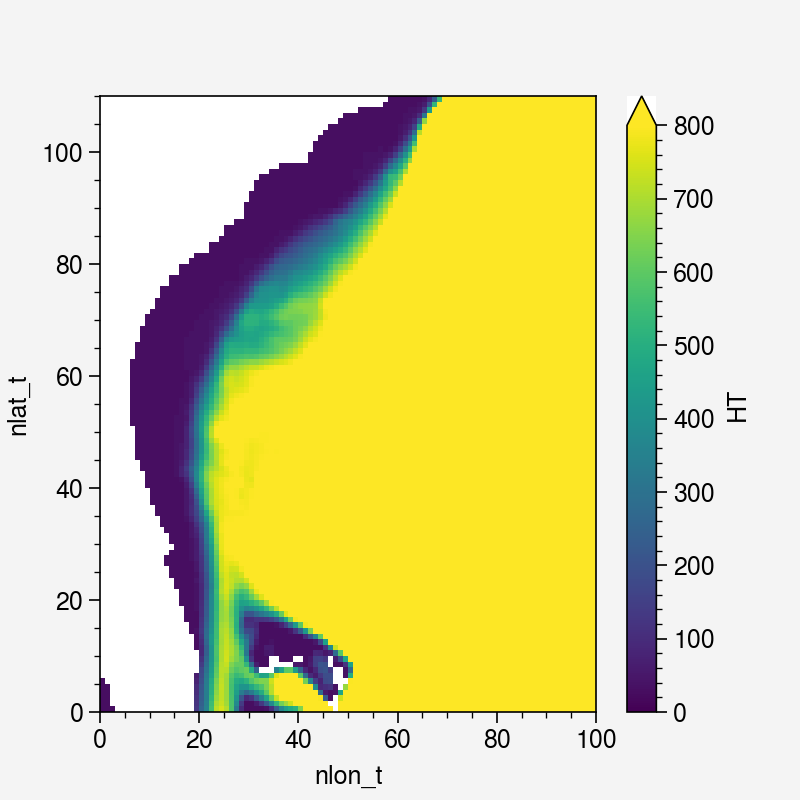

In [19]:
(xds_pd_r_TH.HT.where(kmt_r_TH>0,np.nan)/100).plot(vmin=0,vmax=800)

In [15]:
# ilat1_t12, ilat2_t12 = 1500,1530-20
# ilon1_t12, ilon2_t12 = 280, 380
uet_r2_TH = ds_uet_TH.UET.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
ues_r2_TH = ds_ues_TH.UES.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
uvel_r2_TH = ds_uvel_TH.UVEL.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
temp_r2_TH = ds_temp_TH.TEMP.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
salt_r2_TH = ds_salt_TH.SALT.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
dxt_r2_TH = ds_temp_TH.DXT.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))

alpha = 2.5e-4 # reference, POP manual Eq(8.6) ρ=ρ0−2.5×10−4Θ + 7.6×10−4S,
beta = 7.6e-4

ut_tot_r2_TH = -alpha*uet_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
ut_mfl_r2_TH = -alpha*uvel_r2_TH*temp_r2_TH/dxt_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
ut_eddy_r2_TH = ut_tot_r2_TH - ut_mfl_r2_TH
us_tot_r2_TH = beta*ues_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
us_mfl_r2_TH = beta*uvel_r2_TH*salt_r2_TH/dxt_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
us_eddy_r2_TH = us_tot_r2_TH - us_mfl_r2_TH

urho_tot_r2_TH = ut_tot_r2_TH + us_tot_r2_TH
urho_mfl_r2_TH = ut_mfl_r2_TH + us_mfl_r2_TH
urho_eddy_r2_TH = ut_eddy_r2_TH + us_eddy_r2_TH

urho_mfl_r2_t1av_TH = urho_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
urho_tot_r2_t1av_TH = urho_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
urho_eddy_r2_t1av_TH = urho_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

urho_mfl_r2_t2av_TH = urho_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
urho_tot_r2_t2av_TH = urho_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
urho_eddy_r2_t2av_TH = urho_eddy_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

# ut_mfl_r2_t1av_TH = ut_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# ut_tot_r2_t1av_TH = ut_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# ut_eddy_r2_t1av_TH = ut_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# us_mfl_r2_t1av_TH = us_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# us_tot_r2_t1av_TH = us_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# us_eddy_r2_t1av_TH = us_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# ut_mfl_r2_t2av_TH = ut_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# ut_tot_r2_t2av_TH = ut_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# ut_eddy_r2_t2av_TH = ut_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# us_mfl_r2_t2av_TH = us_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# us_tot_r2_t2av_TH = us_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# us_eddy_r2_t2av_TH = us_eddy_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

temp_r2_t1av_TH = temp_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
temp_r2_t2av_TH = temp_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
uvel_r2_t1av_TH = uvel_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
uvel_r2_t2av_TH = uvel_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

print(ut_mfl_r2_TH.dims)
# print(ut_tot_r2_TH.time[0].values, ut_tot_r2_TH.time[-1].values)

('time', 'z_t', 'nlat', 'nlon')


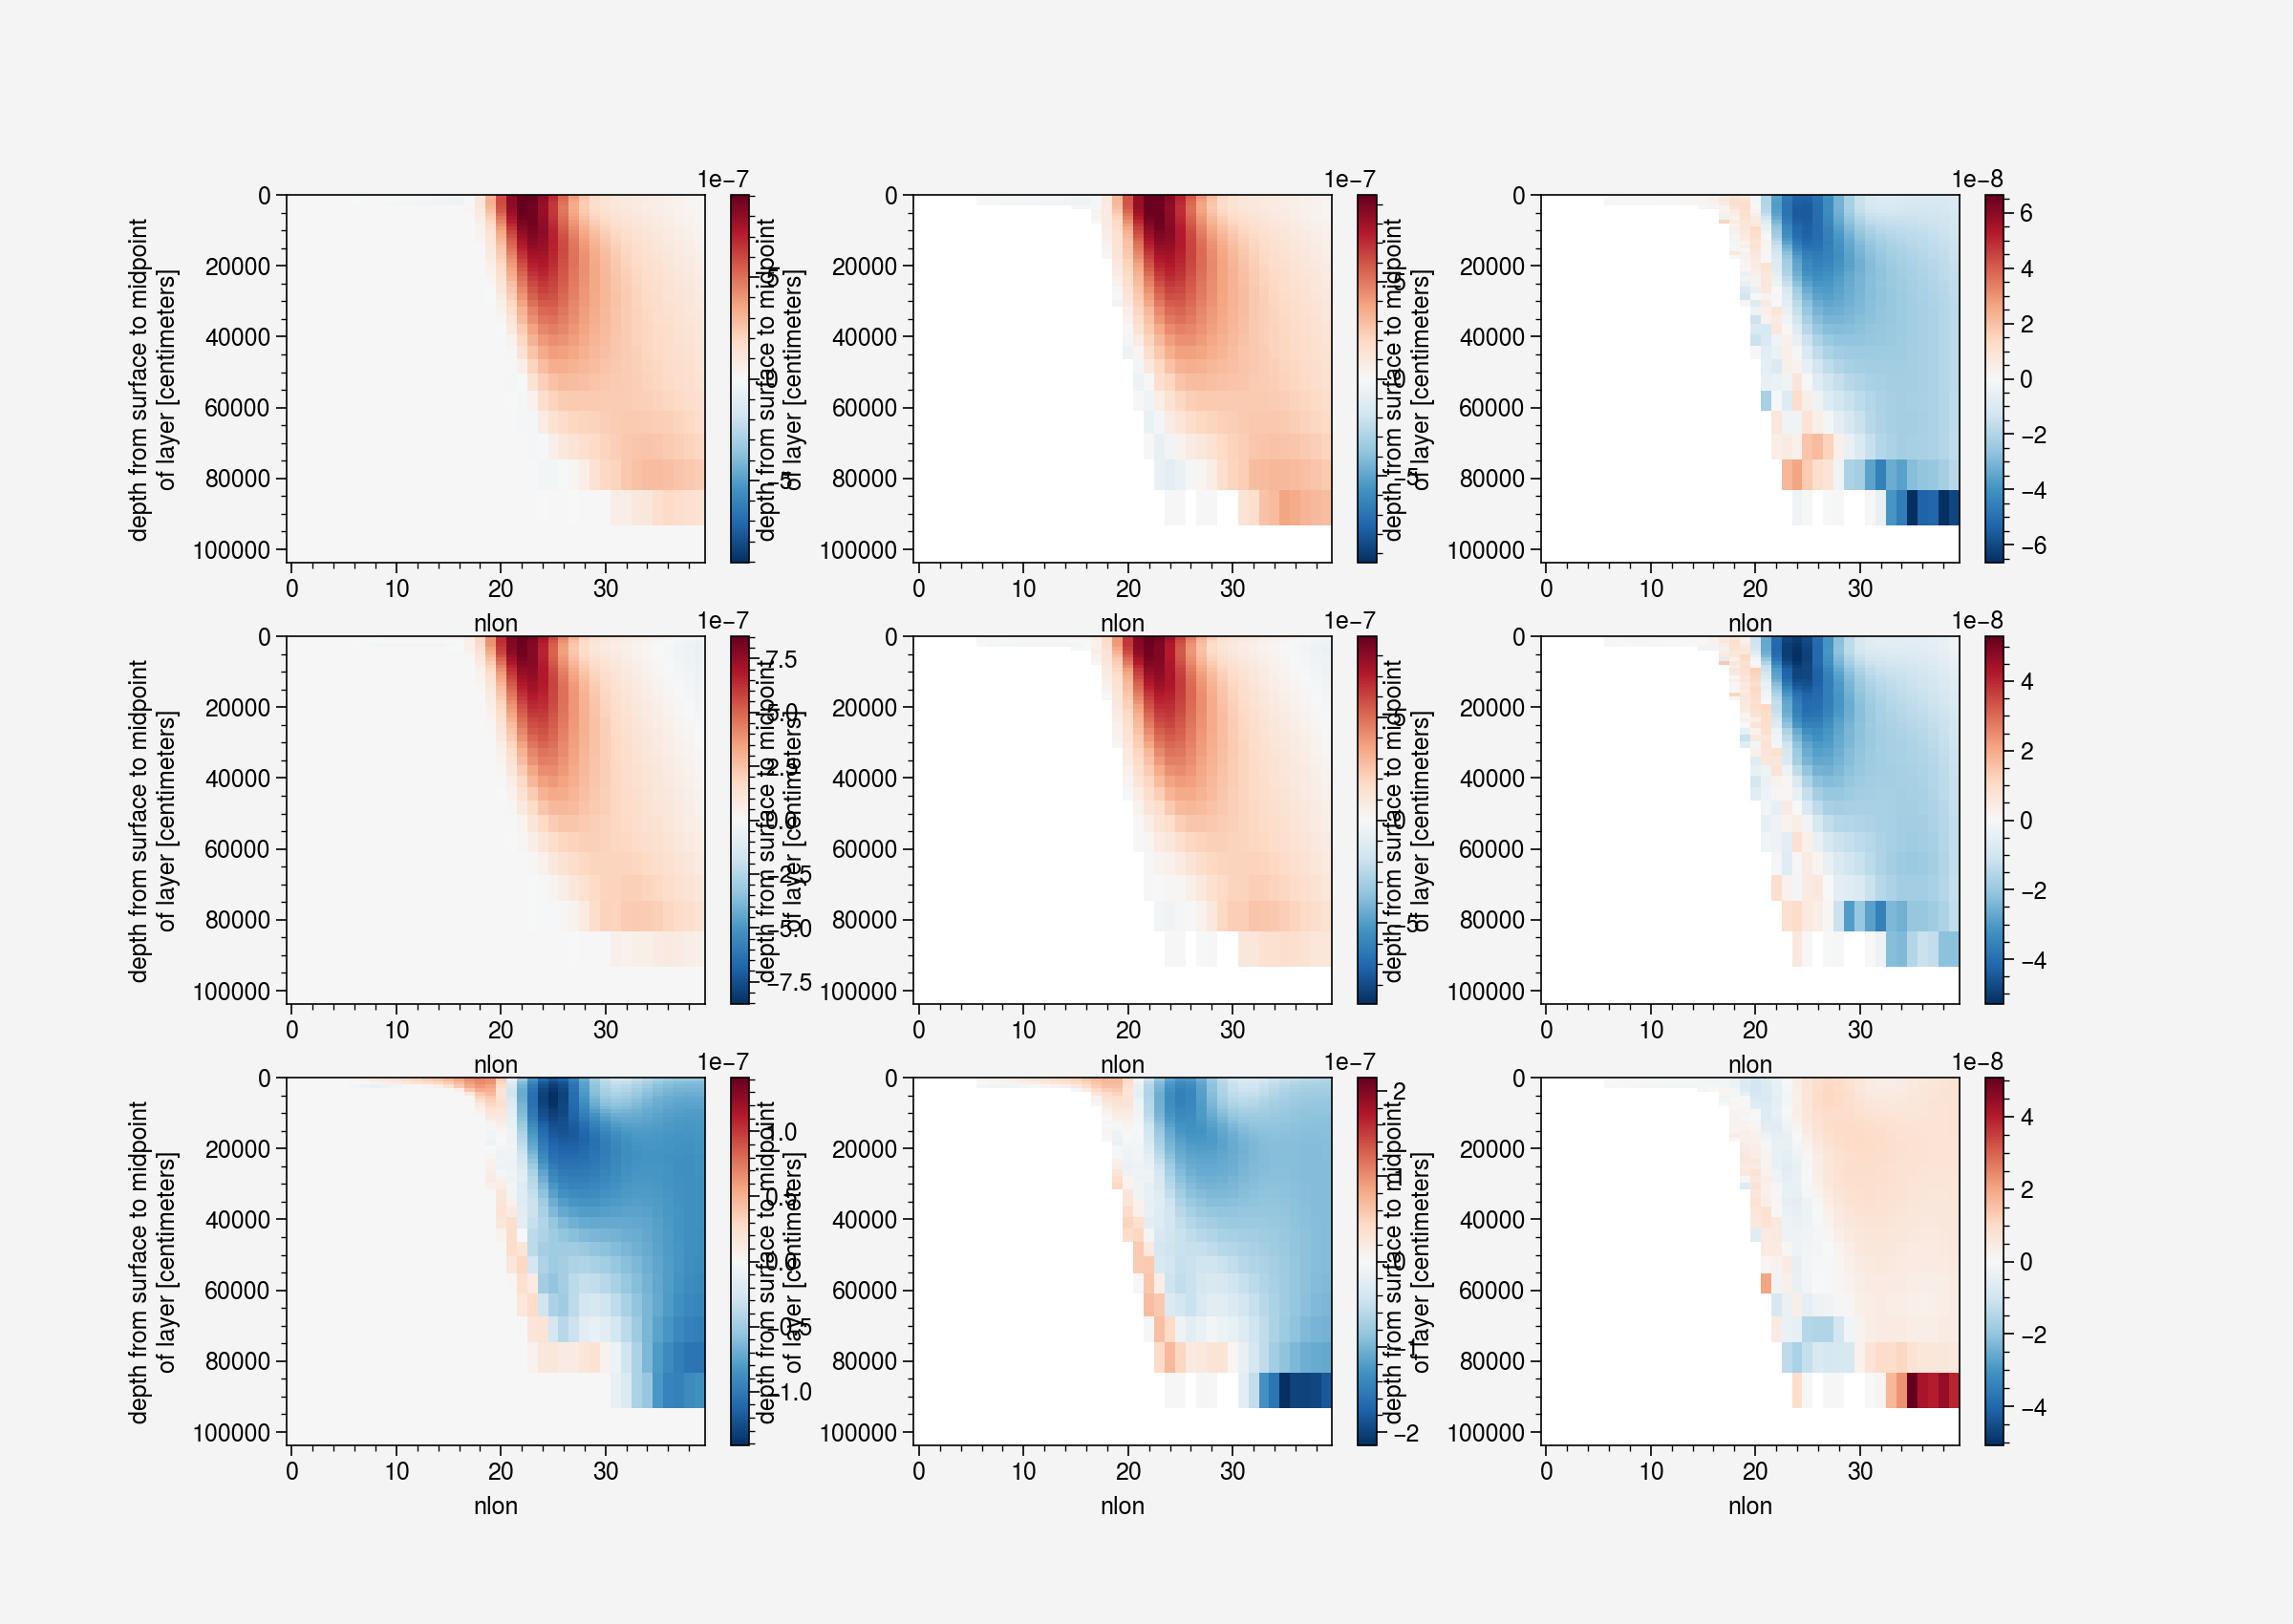

In [16]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
urho_tot_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
urho_mfl_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
urho_eddy_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

urho_tot_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False)
urho_mfl_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False)
urho_eddy_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

(urho_tot_r2_t2av_TH - urho_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
(urho_mfl_r2_t2av_TH - urho_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
(urho_eddy_r2_t2av_TH - urho_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

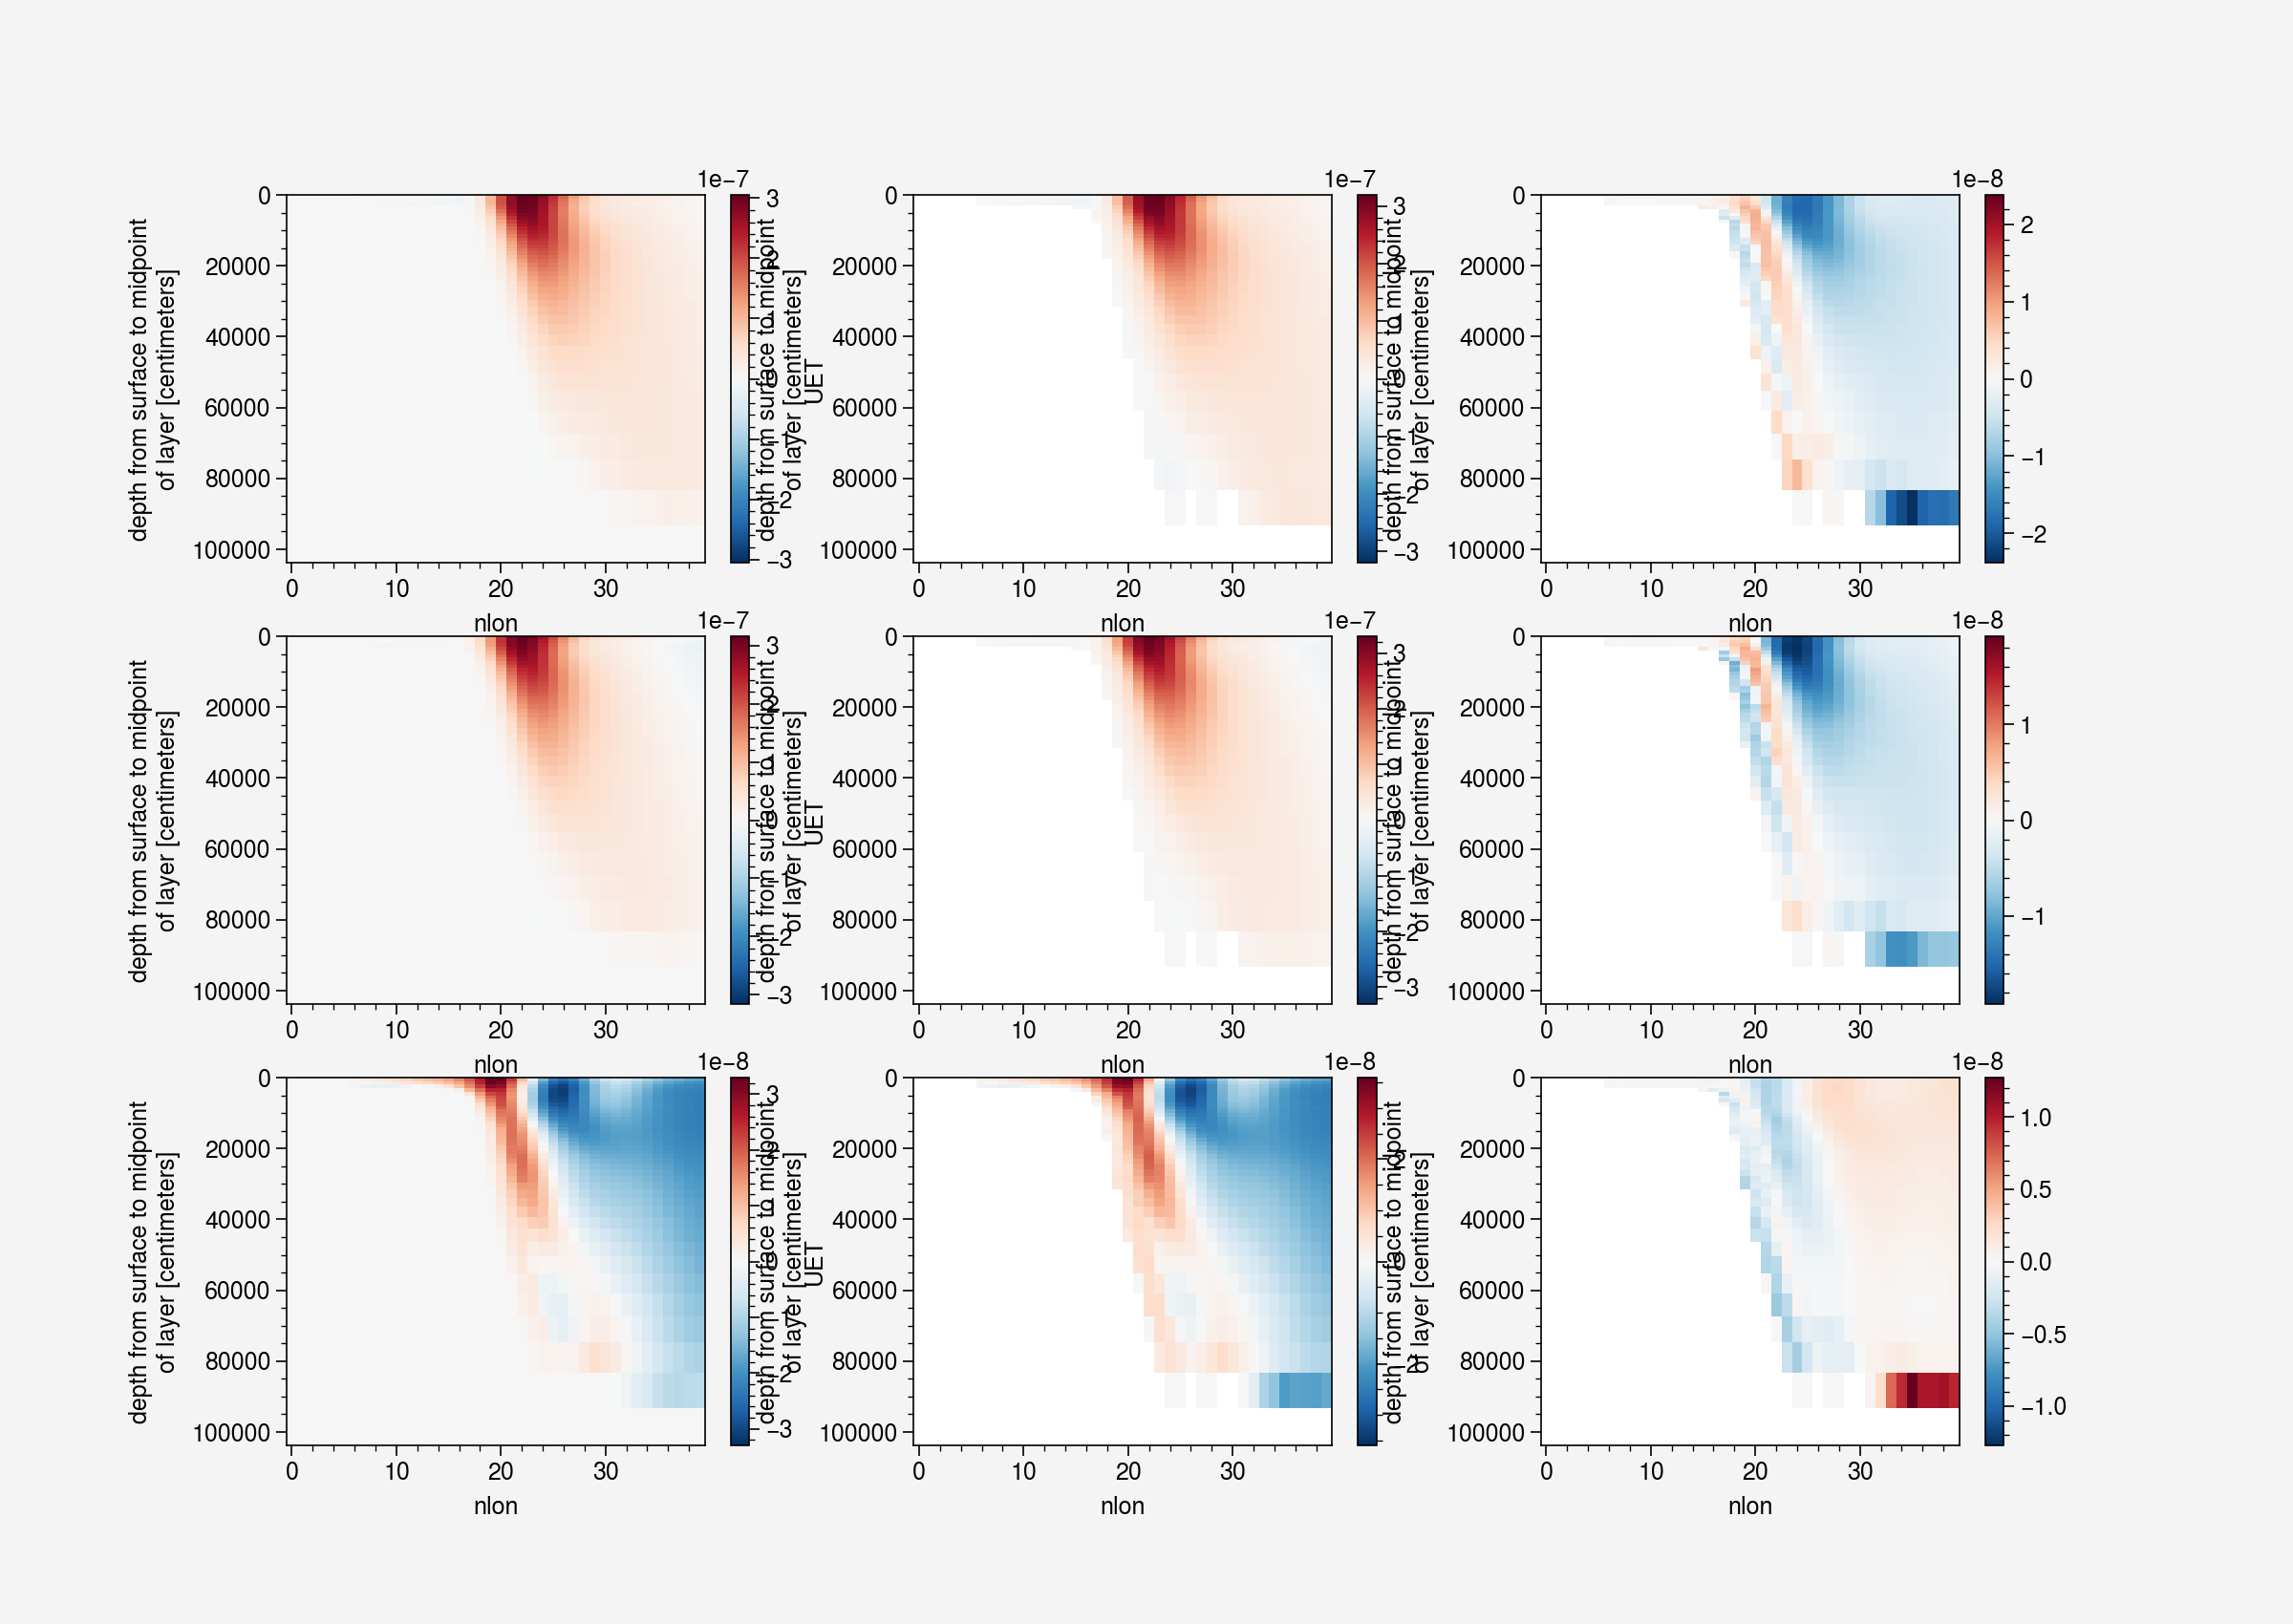

In [28]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
ut_tot_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
ut_mfl_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
ut_eddy_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

ut_tot_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False)
ut_mfl_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False)
ut_eddy_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

(ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
(ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
(ut_eddy_r2_t2av_TH - ut_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

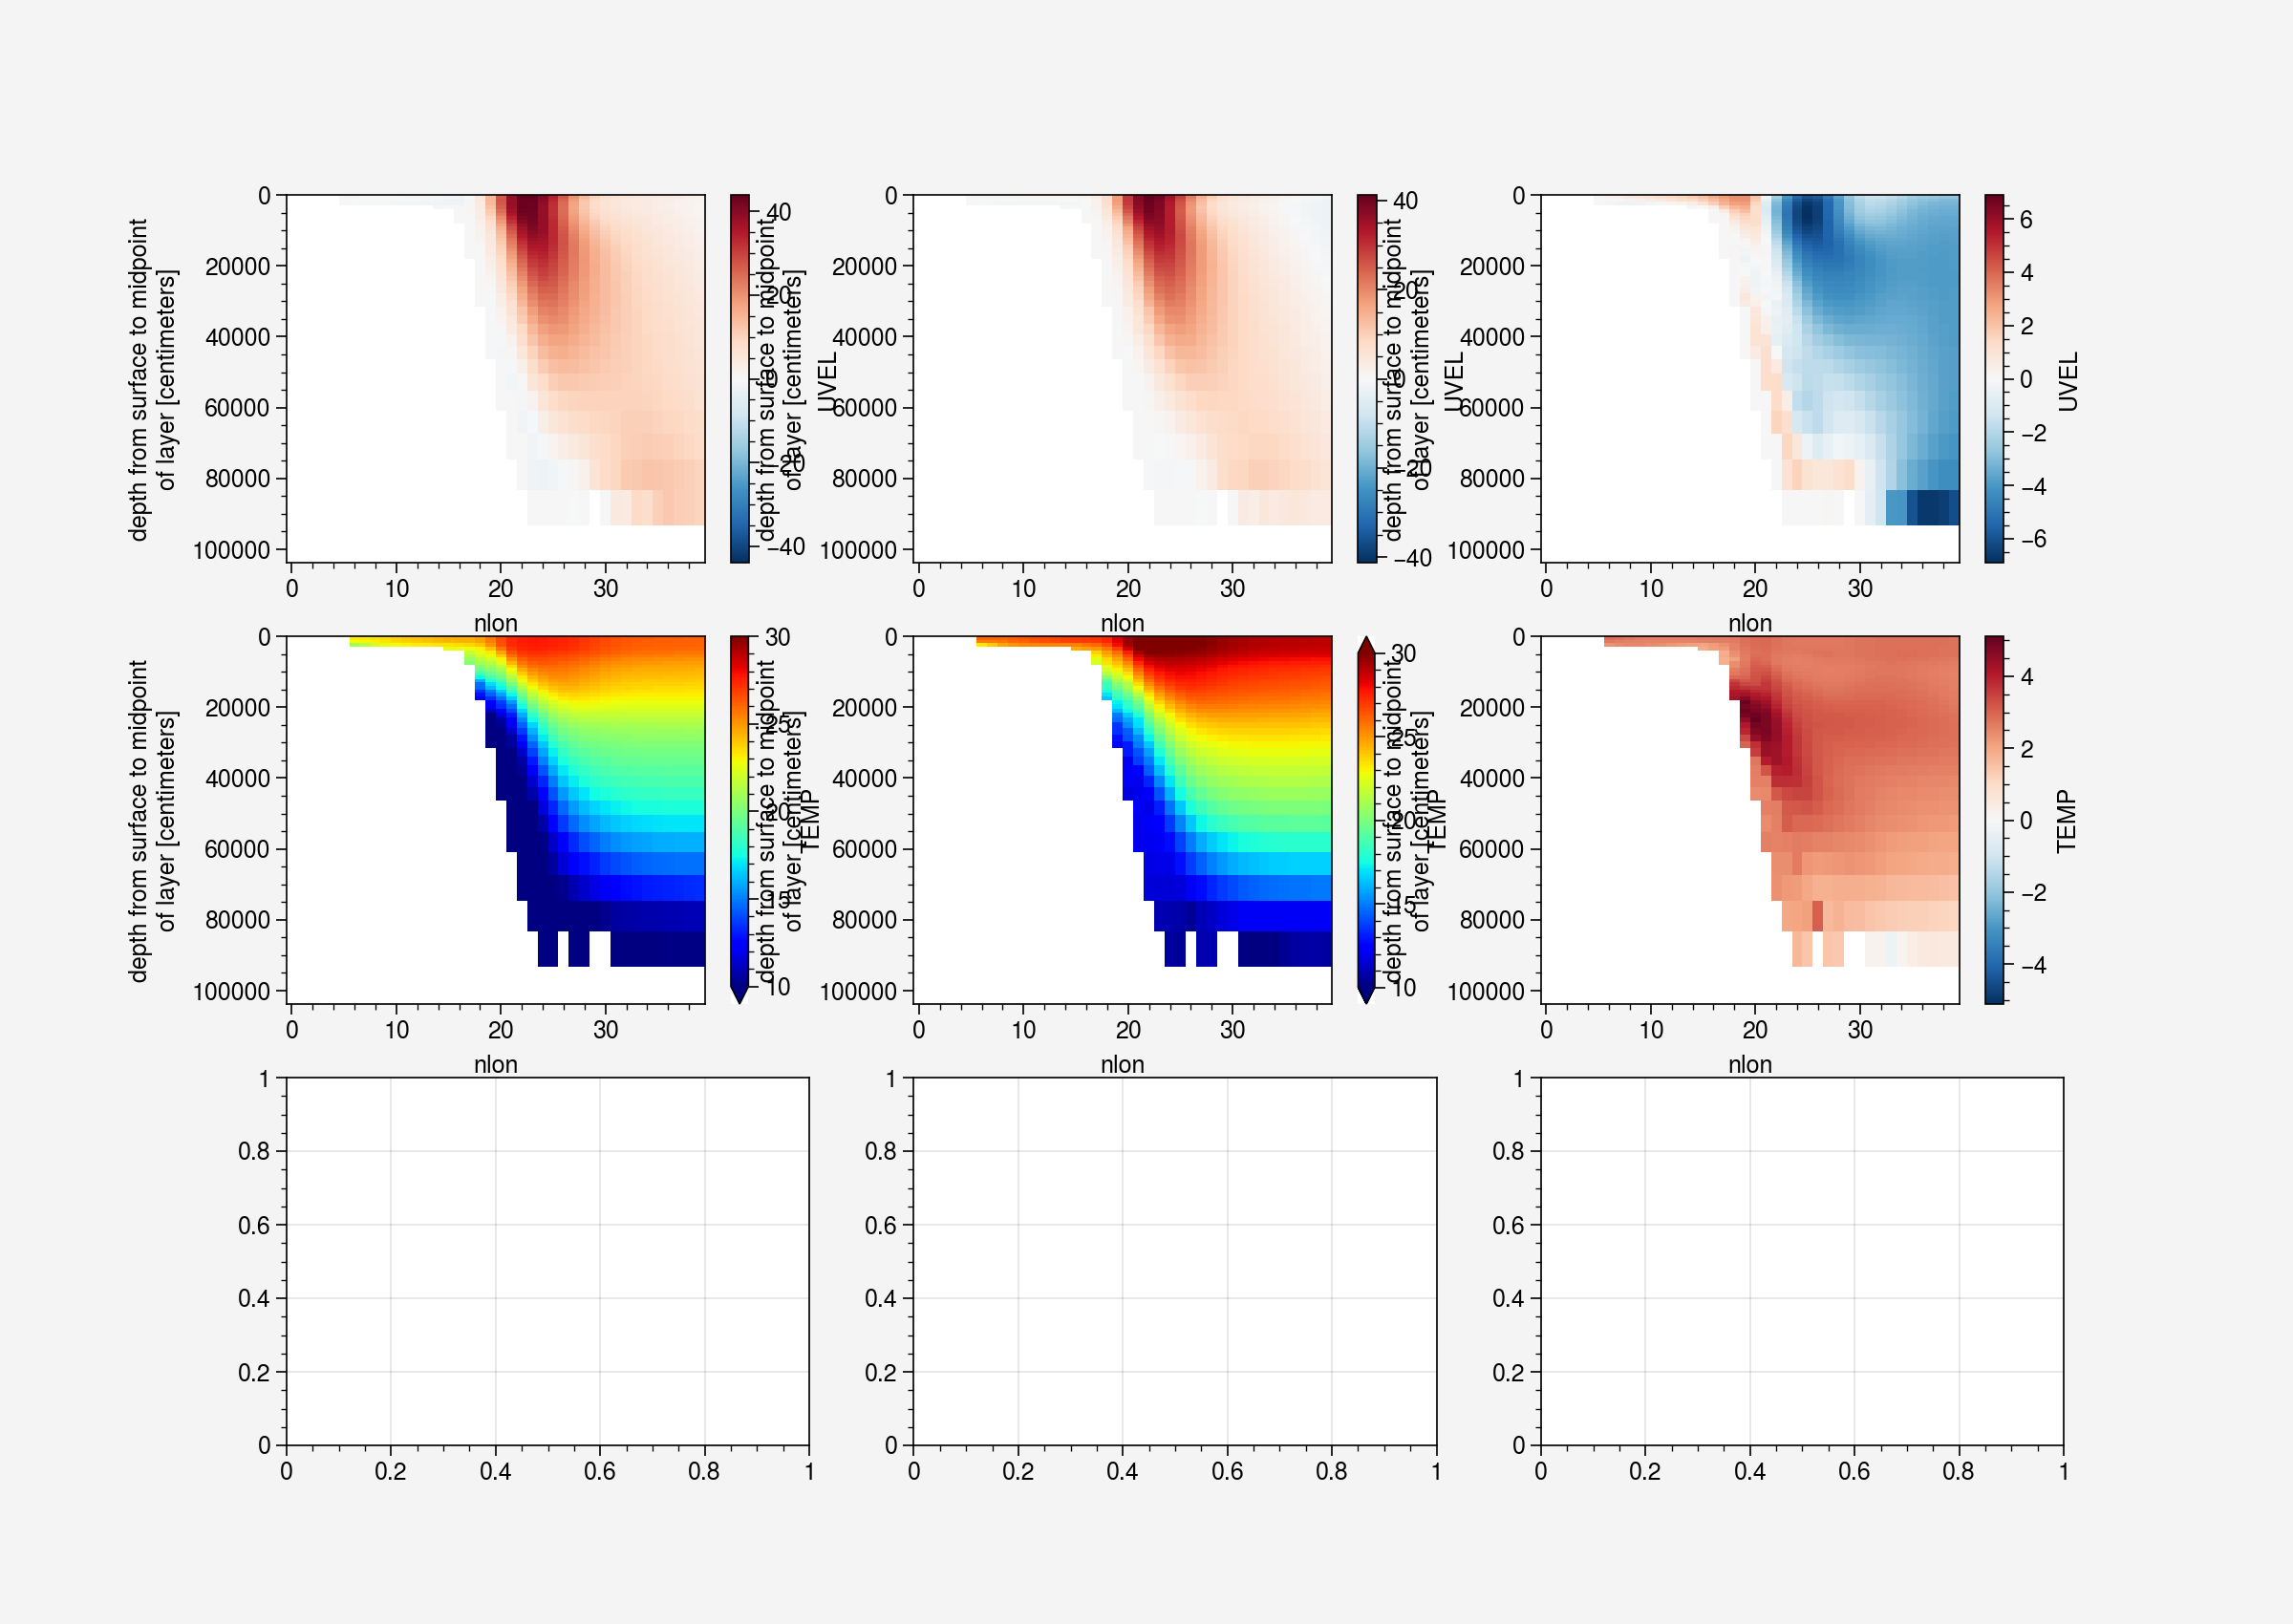

In [38]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
uvel_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
uvel_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
(uvel_r2_t2av_TH-uvel_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

temp_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False,cmap='jet',vmin=10, vmax=30)
temp_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False,cmap='jet',vmin=10, vmax=30)
(temp_r2_t2av_TH-temp_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

# (ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
# (ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
# (ut_eddy_r2_t2av_TH - ut_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

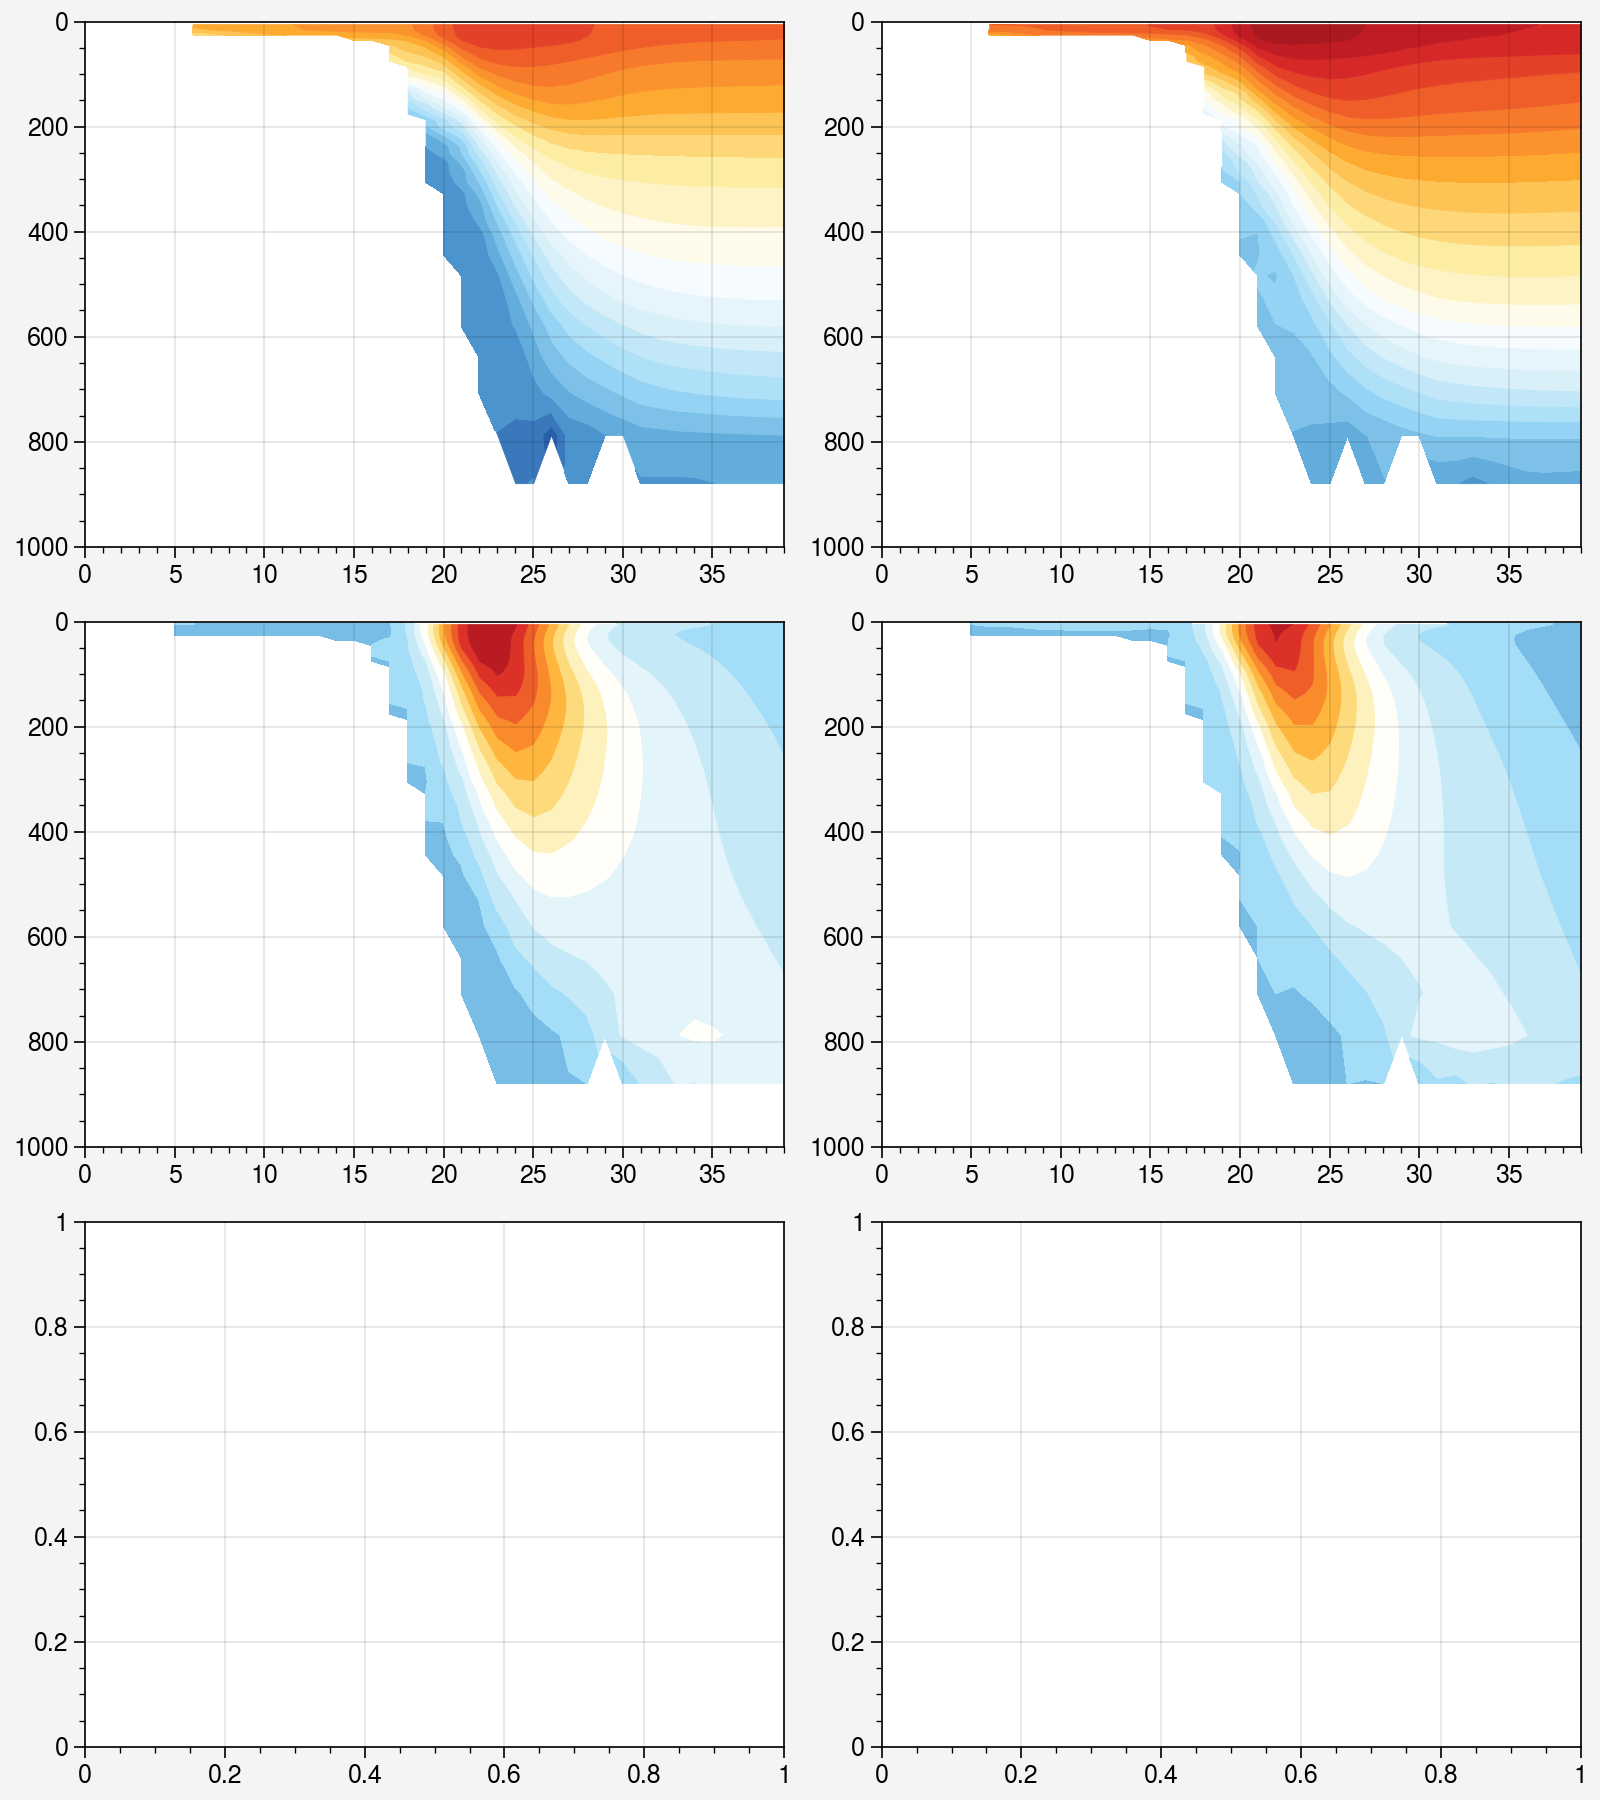

In [105]:
fig1, axs = plot.subplots(nrows=3,ncols=2,width='8in',height='9in',share=False)

# temp_r2_t1av_TH.isel(nlon=slice(0,50),z_t=slice(0,50)).plot(ax=axs[0], yincrease=False,vmin=20, vmax=25, cmap='bwr')
# temp_r2_t2av_TH.isel(nlon=slice(0,50),z_t=slice(0,50)).plot(ax=axs[1], yincrease=False,vmin=20, vmax=25, cmap='bwr')
axs[0, 0].contourf(temp_r2_t1av_TH.nlon.values, temp_r2_t1av_TH.z_t.values/100, temp_r2_t1av_TH.values, levels=np.arange(4,32.01,1), cmap='ColdHot')
# axs[0, 0].set_xlim([278,284])
axs[0, 0].set_ylim([0,1000])
axs[0, 0].invert_yaxis()

axs[0, 1].contourf(temp_r2_t1av_TH.nlon.values, temp_r2_t2av_TH.z_t.values/100, temp_r2_t2av_TH.values, levels=np.arange(4,32.01,1), cmap='ColdHot')
# axs[0, 1].set_xlim([278,284])
axs[0, 1].set_ylim([0,1000])
axs[0, 1].invert_yaxis()

axs[1, 0].contourf(uvel_r2_t1av_TH.nlon.values, uvel_r2_t1av_TH.z_t.values/100, uvel_r2_t1av_TH.values, levels=np.arange(-20,50,4), cmap='ColdHot')
# axs[0, 0].set_xlim([278,284])
axs[1, 0].set_ylim([0,1000])
axs[1, 0].invert_yaxis()

axs[1, 1].contourf(uvel_r2_t2av_TH.nlon.values, uvel_r2_t2av_TH.z_t.values/100, uvel_r2_t2av_TH.values, levels=np.arange(-20,50,4), cmap='ColdHot')
# axs[0, 1].set_xlim([278,284])
axs[1, 1].set_ylim([0,1000])
axs[1, 1].invert_yaxis()



# axs[1, 0].plot(tlon_r2,temp_r2_t1av_TH.mean('z_t')+2.8, color='b')
# axs[1, 0].plot(tlon_r2,temp_r2_t2av_TH.mean('z_t'), color='r')
# axs[1,0].set_xlim([278,284])

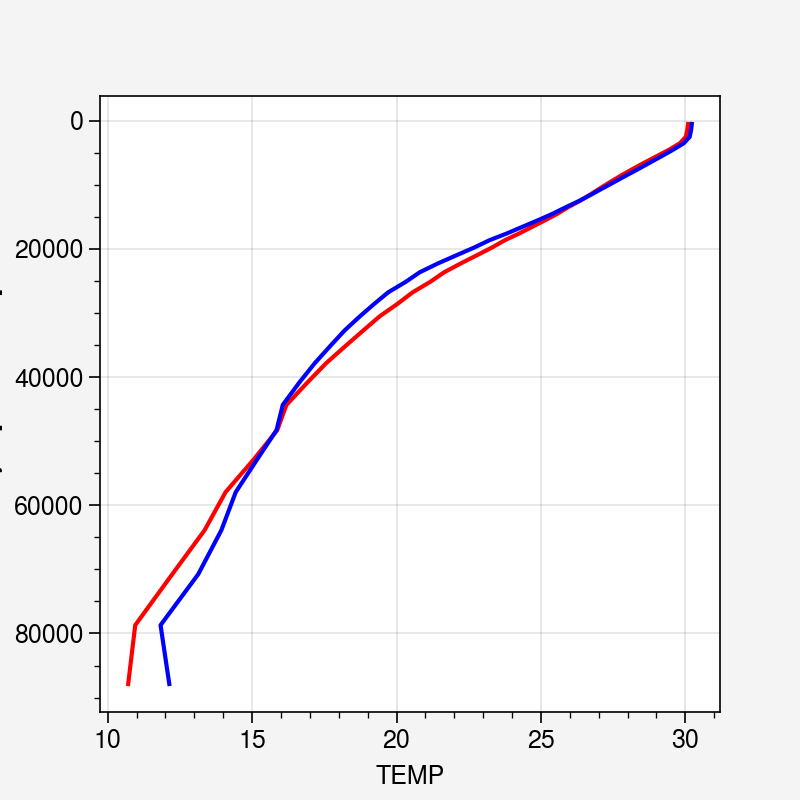

In [100]:
# temp_r2_t1av_TH.mean('z_t').plot(color='b')
# temp_r2_t2av_TH.mean('z_t').plot(color='r')
temp_r2_t2av_TH.sel(nlon=slice(20,30)).mean('nlon').plot(color='r',y='z_t',yincrease=False)
(temp_r2_t1av_TH.sel(nlon=slice(20,30)).mean('nlon')+2.9).plot(color='b',y='z_t',yincrease=False)

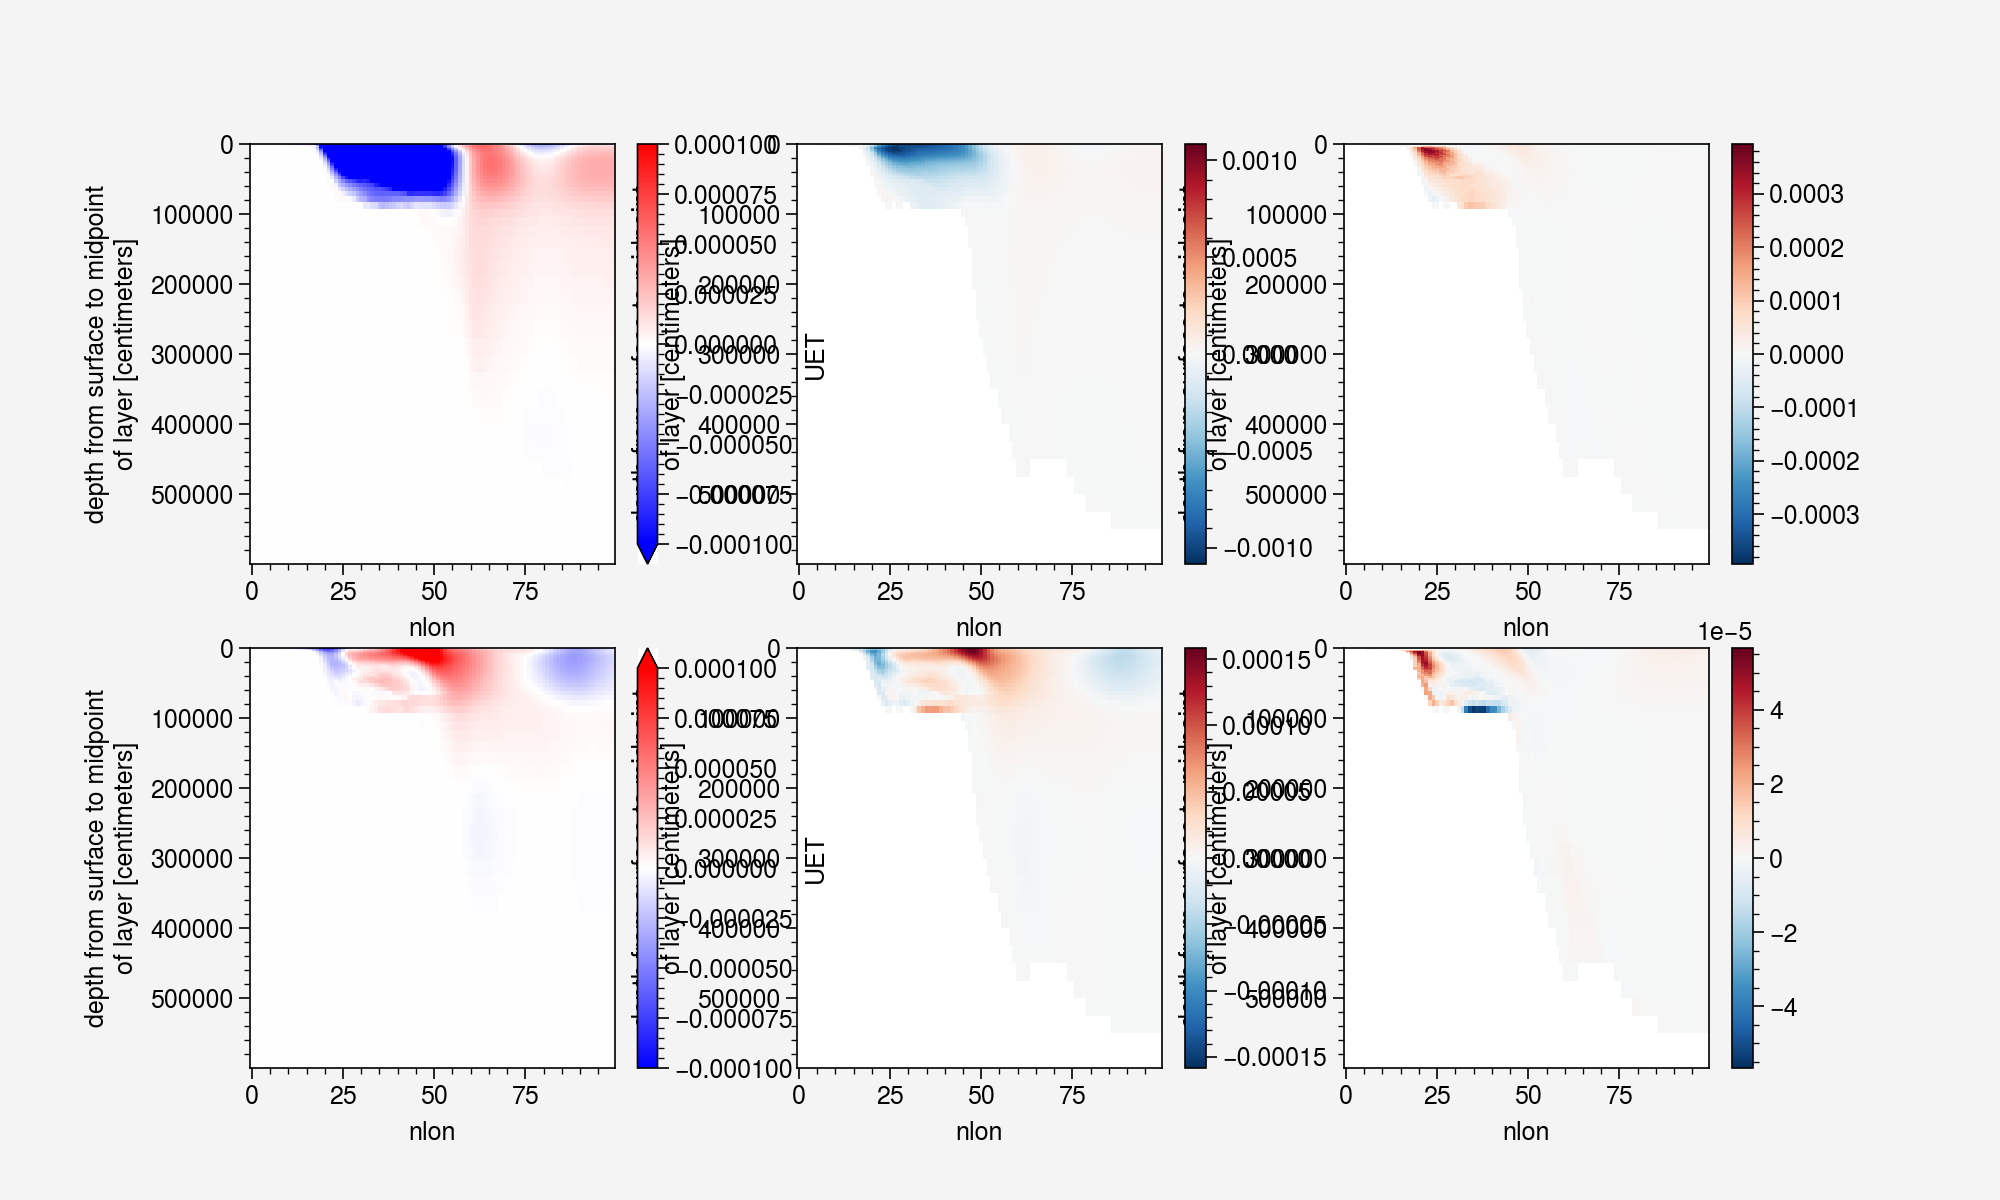

In [10]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
ut_tot_r2_t1av_TH.plot(ax=axs[0,0], yincrease=False, vmin=-1e-4,vmax=1e-4,cmap='bwr')
ut_mfl_r2_t1av_TH.plot(ax=axs[0,1], yincrease=False)
ut_eddy_r2_t1av_TH.plot(ax=axs[0,2], yincrease=False)

(ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).plot(ax=axs[1,0], yincrease=False, vmin=-1e-4,vmax=1e-4,cmap='bwr')
(ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).plot(ax=axs[1,1], yincrease=False)
(ut_eddy_r2_t2av_TH-ut_eddy_r2_t1av_TH).plot(ax=axs[1,2], yincrease=False)

In [8]:
ds_TH = xr.Dataset()
ds_TH

ds_TH["UVEL"] = ds_uvel_TH.UVEL
ds_TH["VVEL"] = ds_vvel_TH.VVEL
ds_TH["TEMP"] = ds_temp_TH.TEMP
ds_TH["SALT"] = ds_salt_TH.SALT
ds_TH["DXU"] = ds_uvel_TH.DXU.compute() # cm
ds_TH["DXT"] = ds_uvel_TH.DXT.compute() # cm
ds_TH["DYU"] = ds_uvel_TH.DYU.compute() # cm
ds_TH["DYT"] = ds_uvel_TH.DYT.compute() # cm
ds_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
ds_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_TH["UAREA"] = ds_uvel_TH.UAREA.compute() # cm2
ds_TH["TAREA"] = ds_uvel_TH.TAREA.compute() # cm2
ds_TH["KMU"] = ds_uvel_TH.KMU.compute() #
ds_TH["KMT"] = ds_uvel_TH.KMT.compute() #
ds_TH.DZT.attrs["long_name"] = "Thickness of T cells"
ds_TH.DZT.attrs["units"] = "centimeter"
ds_TH.DZT.attrs["grid_loc"] = "3111"
ds_TH.DZU.attrs["long_name"] = "Thickness of U cells"
ds_TH.DZU.attrs["units"] = "centimeter"
ds_TH.DZU.attrs["grid_loc"] = "3221"
ds_TH

# ds_hdift_r_TL = ds_hdift_TL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), nlat=slice(nlat1_r_g16, nlat2_r_g16))
ds_r_TH = ds_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))

# ds_hdift_tre_r_TL = ds_hdift_TL.resample(time='A').mean('time')
# ds_uvel_tre_r_TL = ds_uvel_TL.resample(time='A').mean('time')
ds_r_TH

print('loop start')
# make sure we have the cell volumne for calculations
VOL = (ds_r_TH.DZT * ds_r_TH.DXT * ds_r_TH.DYT).compute()
KMT = ds_r_TH.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds_r_TH["VOL"] = VOL

ds_r_TH.VOL.attrs["long_name"] = "volume of T cells"
ds_r_TH.VOL.attrs["units"] = "centimeter^3"

ds_r_TH.VOL.attrs["grid_loc"] = "3111"


metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],}

grid_r_TH, xds_r_TH = pop_tools.to_xgcm_grid_dataset(ds_r_TH, 
                                                             periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)


for coord in ["nlat", "nlon"]:
    if coord in xds_r_TH.coords:
        xds_r_TH = xds_r_TH.drop_vars(coord)
        
xds_r_TH

loop start


100%|██████████| 500/500 [00:00<00:00, 849.06it/s]


<xarray.Dataset>
Dimensions:  (nlat_t: 500, nlat_u: 500, nlon_t: 400, nlon_u: 400, time: 1200, z_t: 62)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
Data variables: (12/15)
    UVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    VVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    TEMP     (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    SALT     (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    DXU      (nlat_u, nlon_u) float64 1.035e+06 1.035e+06 ... 6.221e+05
    DXT      (nlat_t, nlon_t) float64 1.036e+06 1.036e+06 ... 6.225e+05
    ...       ...
    DZT      (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 1e+03 ... nan nan nan
    UAREA    (nlat_u, nlon_u) float64 1.072e+12 1.072e+12 ... 4.265e+11
    TAREA    (nlat_t, nlon_t) float64 1.073e+12 1.073e+12 ... 4.269e+11
    KMU      (nlat_u, nlon_u) float64 52.0 53.0 54.0 54.0 ... 47.0 44.0 39.0
    KMT      (nlat_t, nlon_t) float64 54.0 54.0 55.0 55.0 ... 49.0 49.0 47.0
    VOL      (z_t, nlat_t, nlon_t) float64 1.073e+15 1.073e+15 ... 0.0 0.0

In [9]:
# uvel_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.UVEL, 'Y')
# uvel_yintp_r_TH
uvel_yintp_r_TH = grid_r_TH.interp(xds_r_TH.UVEL, 'Y')
uvel_yintp_r_TH

<xarray.DataArray 'mul-036140d16dc626d5c8a6d9e190ecf64a' (time: 1200, z_t: 62, nlat_t: 500, nlon_u: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 299, 250), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400

In [10]:
# vvel_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.VVEL, 'X')
# vvel_xintp_r_TH
vvel_xintp_r_TH = grid_r_TH.interp(xds_r_TH.VVEL, 'X')
vvel_xintp_r_TH

<xarray.DataArray 'mul-66b43733520dcc8f089593d5a2fcd40d' (time: 1200, z_t: 62, nlat_u: 500, nlon_t: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 300, 249), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5

In [11]:
# xds_uvel_r_TH.TEMP
# temp_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.TEMP, 'X')
# salt_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.SALT, 'X')
# temp_xintp_r_TH
xds_r_TH.TEMP
temp_xintp_r_TH = grid_r_TH.interp(xds_r_TH.TEMP, 'X')
salt_xintp_r_TH = grid_r_TH.interp(xds_r_TH.SALT, 'X')
temp_xintp_r_TH

<xarray.DataArray 'mul-cf1edab6648a9cb60f3fe58ab0b8c58e' (time: 1200, z_t: 62, nlat_t: 500, nlon_u: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 300, 249), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400

In [12]:
# temp_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.TEMP, 'Y')
# salt_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.SALT, 'Y')
# temp_yintp_r_TH
temp_yintp_r_TH = grid_r_TH.interp(xds_r_TH.TEMP, 'Y')
salt_yintp_r_TH = grid_r_TH.interp(xds_r_TH.SALT, 'Y')
temp_yintp_r_TH

<xarray.DataArray 'mul-9b1d4452c206b7af55a2445a1d7ef7f7' (time: 1200, z_t: 62, nlat_u: 500, nlon_t: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 299, 250), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5

In [13]:
uet_mfl_r_TH = uvel_yintp_r_TH*temp_xintp_r_TH
ues_mfl_r_TH = uvel_yintp_r_TH*salt_xintp_r_TH
uet_mfl_r_TH

<xarray.DataArray (time: 1200, z_t: 62, nlat_t: 500, nlon_u: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 299, 249), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400

In [14]:
vnt_mfl_r_TH = vvel_xintp_r_TH*temp_yintp_r_TH
vns_mfl_r_TH = vvel_xintp_r_TH*salt_yintp_r_TH
vnt_mfl_r_TH

<xarray.DataArray (time: 1200, z_t: 62, nlat_u: 500, nlon_t: 400)>
dask.array<mul, shape=(1200, 62, 500, 400), dtype=float32, chunksize=(12, 62, 299, 249), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5

In [15]:
# vnt_mfl_r_TH.isel(time=0,z_t=0).plot(robust=True) # [cm/s*degC]
uet_mfl_r_TH.dims

('time', 'z_t', 'nlat_t', 'nlon_u')

In [16]:
# duet_mfl_r_TH = -(grid_uvel_r_TH.diff(uet_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="X") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DXT
# # [degC/s]
# dvnt_mfl_r_TH = -(grid_uvel_r_TH.diff(vnt_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="Y") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DYT
# hdivt_mfl_r_TH = (duet_mfl_r_TH + dvnt_mfl_r_TH)

# dues_mfl_r_TH = -(grid_uvel_r_TH.diff(ues_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="X") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DXT
# # [psu/s]
# dvns_mfl_r_TH = -(grid_uvel_r_TH.diff(vns_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="Y") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DYT
# hdivs_mfl_r_TH = (dues_mfl_r_TH + dvns_mfl_r_TH)

duet_mfl_r_TH = -(grid_r_TH.diff(uet_mfl_r_TH * xds_r_TH.VOL.values, axis="X") / xds_r_TH.VOL)/xds_r_TH.DXT
# [degC/s]
dvnt_mfl_r_TH = -(grid_r_TH.diff(vnt_mfl_r_TH * xds_r_TH.VOL.values, axis="Y") / xds_r_TH.VOL)/xds_r_TH.DYT
hdivt_mfl_r_TH = (duet_mfl_r_TH + dvnt_mfl_r_TH)

dues_mfl_r_TH = -(grid_r_TH.diff(ues_mfl_r_TH * xds_r_TH.VOL.values, axis="X") / xds_r_TH.VOL)/xds_r_TH.DXT
# [psu/s]
dvns_mfl_r_TH = -(grid_r_TH.diff(vns_mfl_r_TH * xds_r_TH.VOL.values, axis="Y") / xds_r_TH.VOL)/xds_r_TH.DYT
hdivs_mfl_r_TH = (dues_mfl_r_TH + dvns_mfl_r_TH)

hdivt_mfl_r_TH 

<xarray.DataArray (time: 1200, z_t: 62, nlat_t: 500, nlon_t: 400)>
dask.array<add, shape=(1200, 62, 500, 400), dtype=float64, chunksize=(12, 62, 298, 248), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>

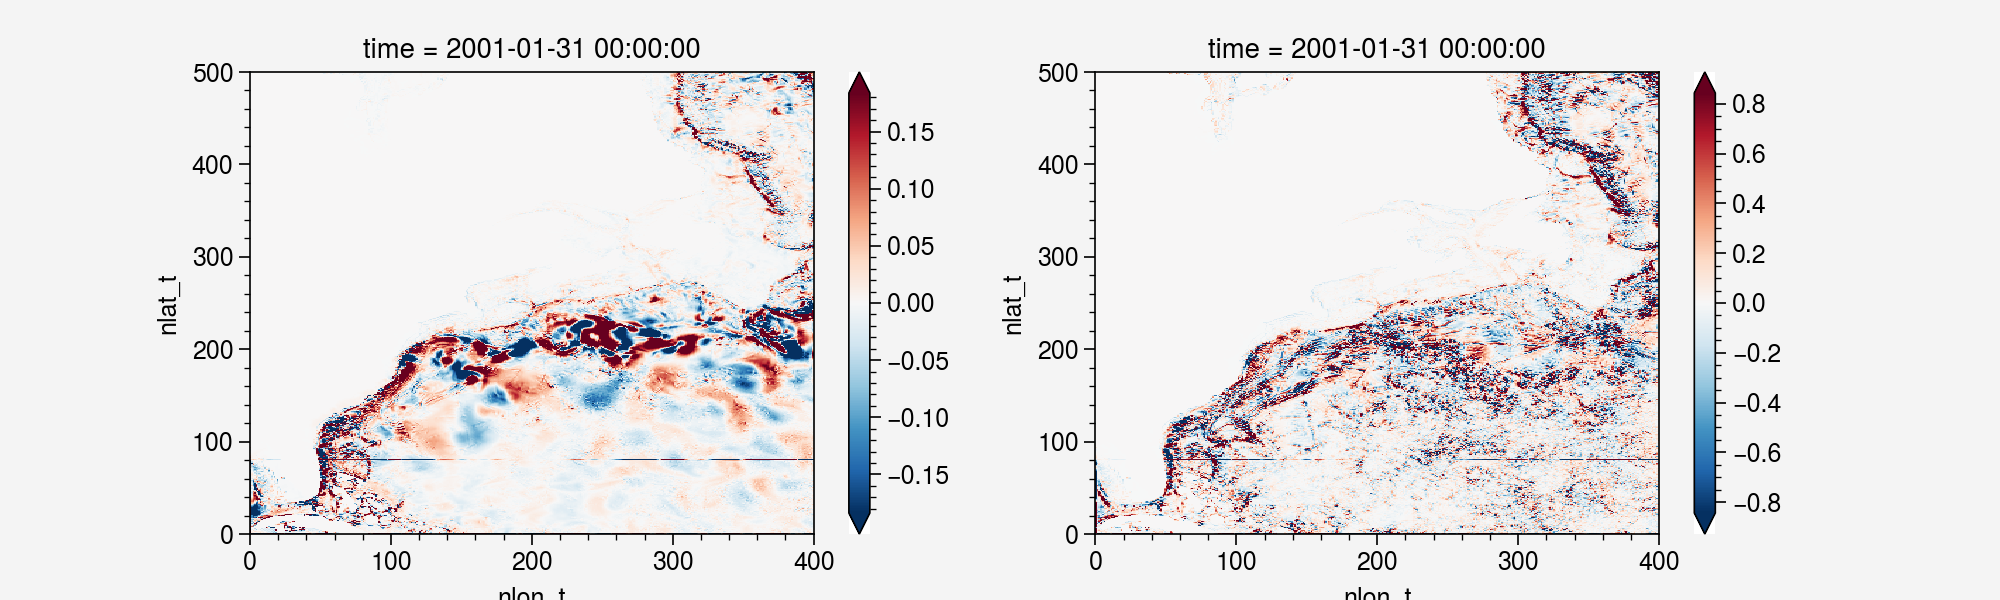

In [17]:
# hdivt_mfl_intz_r_TH = (hdivt_mfl_r_TH*xds_uvel_r_TH.DZT).sum('z_t') # [degC/s*cm]
# hdivt_mfl_intz_r_TH
# hdivs_mfl_intz_r_TH = (hdivs_mfl_r_TH*xds_uvel_r_TH.DZT).sum('z_t') # [psu/s*cm]
# hdivs_mfl_intz_r_TH
hdivt_mfl_intz_r_TH = (hdivt_mfl_r_TH*xds_r_TH.DZT).sum('z_t') # [degC/s*cm]
hdivt_mfl_intz_r_TH
hdivs_mfl_intz_r_TH = (hdivs_mfl_r_TH*xds_r_TH.DZT).sum('z_t') # [psu/s*cm]
hdivs_mfl_intz_r_TH

fig, axs = plt.subplots(1,2,figsize=(10,3))
hdivt_mfl_intz_r_TH.isel(time=0).plot(ax=axs[0], robust=True)
hdivs_mfl_intz_r_TH.isel(time=0).plot(ax=axs[1], robust=True)

# save outputs

In [18]:
%%time
outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')
# save yearly data to a file, dask stop responding if outputs more years to a file (possibly due to one worker concatenates too many time)
# for iyr in np.arange(2001,2021):
# for iyr in np.arange(2081,2101):
for iyr in np.arange(2046,2081):
    print('work on '+ str(iyr))
    yr1_str = str(iyr)+'01'
    yr2_str = str(iyr)+'12'
    hdivt_mfl_intz_r_TH.sel(time=slice(yr1_str,yr2_str)).to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_'+str(iyr)+'_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)
    hdivs_mfl_intz_r_TH.sel(time=slice(yr1_str,yr2_str)).to_netcdf(path=(outdir+'meanflow_salt_flux_HR_US_'+str(iyr)+'_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)

work on 2046
work on 2047
work on 2048
work on 2049
work on 2050
work on 2051
work on 2052
work on 2053
work on 2054
work on 2055
work on 2056
work on 2057
work on 2058
work on 2059
work on 2060
work on 2061
work on 2062
work on 2063
work on 2064
work on 2065
work on 2066
work on 2067
work on 2068
work on 2069
work on 2070
work on 2071
work on 2072
work on 2073
work on 2074
work on 2075
work on 2076
work on 2077
work on 2078
work on 2079
work on 2080
CPU times: user 16.3 s, sys: 5.59 s, total: 21.9 s
Wall time: 14min 43s


In [19]:
# %%time
# hdivs_mfl_intz_r_TH.sel(time=slice('2021','2040')).to_netcdf(path=(outdir+'meanflow_salt_flux_HR_US_202101_204012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)
# hdivt_mfl_intz_r_TH.sel(time=slice('2021','2040')).to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_202101_204012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)

In [23]:
# %%time
# outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')

# hdivt_mfl_intz_r_TH.to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_200101_210012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)

# Appendix